# Redes Neuronales en Texto

El objetivo de este taller que aprendan a construir redes neuronales para procesar texto. Comenzaremos con métodos clásicos y terminaremos con modelos más recientes como Transformers y modelos pre-entrenados para NLP. Se espera que lo aprendido sea aplicado activamente al próximo desafío del curso: reconocer discursos de odio en dialecto chileno. Recuerde siempre que el objetivo es aprender. Manténgase resiliente y disfrute el tiempo que puede dedicarle a esto.

<table align='left'>
<tr>
<td><img src='https://d14b9ctw0m6fid.cloudfront.net/ugblog/wp-content/uploads/2019/04/70862042.png' width='650'/></td>
</tr>
</table>



# Base Imports & Utilities

In [9]:
from tensorflow import keras
import seaborn as sns; sns.set()
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import os

In [2]:
from keras.optimizers import Adam
from tensorflow.keras.layers import Dense

In [ ]:
!pip install imblearn

In [ ]:
!pip install tensorflow_addons

In [3]:
#Credits: https://www.tensorflow.org/
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history, metrics = ['accuracy', 'F1']):
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.history[metric], color=colors[0], label='train')
    plt.plot(history.history['val_'+metric],
             color=colors[0], linestyle="--", label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [4]:
#requiere predicciones categóricas
def get_detailed_report(y_true_test, y_pred_test, class_names):
  acc_test = np.mean(y_true_test == y_pred_test)
  print("\nACCURACY: " , acc_test )
  print("\nConfusion Matrix\n")
  fig, ax = plt.subplots(figsize=(6, 6))
  cm = confusion_matrix(y_true_test, y_pred_test)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  plt.rcParams.update({'font.size': 9})
  plt.rc('xtick', labelsize=9)
  plt.rc('ytick', labelsize=9)
  plt.xlabel('Predicted Label', fontsize=9)
  plt.ylabel('True Label', fontsize=9)
  disp = disp.plot(ax=ax,cmap=plt.cm.Blues)
  plt.show()
  print("\nClassification Report\n")
  print(classification_report(y_true_test, y_pred_test, target_names=class_names))

# Datos & Métricas

Los datos que usaremos forman parte de un corpus de textos cortos recolectados desde *Twitter* y clasificados como ejemplos de 5 emociones diferentes: tristeza (sadness), alegría (joy), love (amor), ira (anger), miedo (fear), y sorpresa (surprise). La tarea consiste en construir un algoritmo que permita detectar automáticamente el sentimiento que se expresa en un texto.

Para facilitar la experimentación, dispondrán de particiones de entrenamiento, validación, y pruebas fijas y de tamaño reducido. Los estudiantes más osados pueden más tarde evaluar si una mayor cantidad de ejemplos cambia los resultados observados.

In [ ]:
!curl www.inf.utfsm.cl/~jnancu/tweet_emotions_train.csv
!curl www.inf.utfsm.cl/~jnancu/tweet_emotions_val.csv
!curl www.inf.utfsm.cl/~jnancu/tweet_emotions_test.csv
!curl www.inf.utfsm.cl/~jnancu/tweet_emotions_extratrain.csv

A lo largo de todo el taller la calidad de las predicciones debe ser evaluada considerando Macro Score F1. Junto a eso, se debe investigar el desempeño sobre cada clase individualmente.

# Instrucciones

La tarea consiste en abordar todas las preguntas identificadas con una viñeta. Como se trata de una tarea guiada, su trabajo será evaluado en términos de:

1.  Completitud: se abordaron las preguntas?
2.  Correctitud: se abordaron correctamente las preguntas?
3.  Profundidad: se razona y discute sobre los experimentos y resultados obtenidos?, se demuestra interés y dominio de los temas?
2.  Claridad: se exponen las respuestas de modo claro, dejando fuera aspectos superfluos, de modo que un lector puede entender con facilidad el trabajo realizado y lo que se aprendió a hacer en el taller?



# 1. Lectura & Mini-Exploración


1.   ¿De cuántos datos se dispone en cada partición? ¿Están las clases equitativamente representadas en el conjunto de entrenamiento? ¿Puede esto tener un impacto en los resultados observados sobre el conjunto de pruebas? ¿Qué puede decir de la distribución del largo de los textos en las diferentes clases?


In [10]:
path='data/'#indique correctamente donde están los datos

emotions = [ "sadness", "joy", "love", "anger", "fear", "surprise"]
data_train = pd.read_csv(path+'tweet_emotions_train.csv')
data_val = pd.read_csv(path+'tweet_emotions_val.csv')
data_test = pd.read_csv(path+'tweet_emotions_test.csv')

print(data_train.shape)
print(data_val.shape)
print(data_test.shape)

data_train.head(5)

(5000, 2)
(5000, 2)
(5000, 2)


,tweet,emotion
0,i feel his amorous allure then he smiles and i...,love
1,i woke up still feeling a bit morose,sadness
2,i just sit there not feeling not caring,love
3,i also had a gazillion other things that just ...,fear
4,i feel my ability to read others mind may the ...,sadness


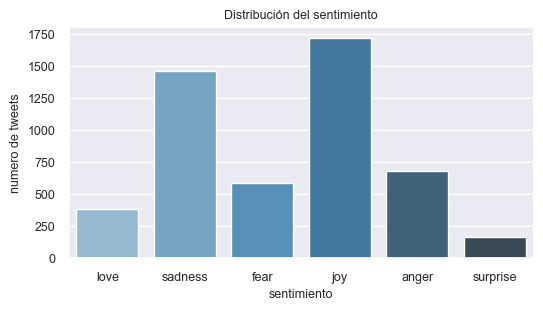

In [6]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

print("\n")
fig, ax = plt.subplots(figsize=(6,3),nrows=1)
sns.countplot(x=data_train['emotion'],palette="Blues_d")
ax.set_title('Distribución del sentimiento',fontsize=9)
ax.tick_params(axis='both', which='major', labelsize=9)
ax.set_xlabel("sentimiento",fontsize=9)
ax.set_ylabel("numero de tweets",fontsize=9)
plt.show()


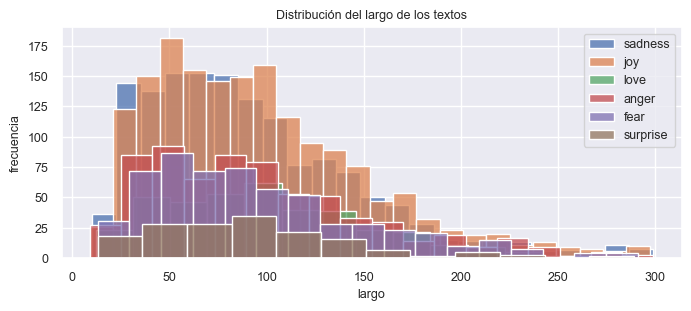

In [7]:
fig, ax = plt.subplots(figsize=(8,3),nrows=1)
for emotion in emotions:
  data = data_train[data_train['emotion']==emotion]
  lengths = data['tweet'].str.len()
  sns.histplot(lengths,label=emotion)

ax.set_title('Distribución del largo de los textos',fontsize=9)
ax.set_xlabel("largo",fontsize=9)
ax.set_ylabel("frecuencia",fontsize=9)
ax.tick_params(axis='both', which='major', labelsize=9)
ax.legend(fontsize=9)
plt.show()

In [8]:
train_tweets = data_train['tweet'].values
val_tweets = data_val['tweet'].values
test_tweets = data_test['tweet'].values

Cada partición posee 5000 datos. Las clases no están equitativamente representadas en el conjunto de entrenamiento - se puede ver que joy y sadness aparecen con mucha mayor frecuencia que las demás. Esto puede afectar en el entrenamiento al aumentar el riesgo de que el modelo haga sobreajuste, tendiendo a predecir sólo las clases que aparecen con mayor frecuencia.

La distribución de largos de textos es relativamente similar entre clases, siendo poco frecuentes textos de largo menor a 30 aprox., luego teniendo mayores frecuencias en largos entre 50 y 100, y luego decreciendo gradualmente al llegar hasta un largo cercano a 300, que es el máximo largo permitido para un tweet.

#  2. Limpieza y Pre-procesamiento

 La metodología más utilizada para representar texto antes de la introducción de los modelos neuronales de lenguaje como BERT, consistía en determinar la *frecuencia* con la que aparecían en el texto las palabras (o elementos más complejos) dentro un diccionario. Este diccionario podía importarse como recurso externo o aprenderse directamente desde los textos disponibles para entrenamiento.

La *limpieza* del texto juega un papel importante en tareas basadas en esta metodología. Por ejemplo, la eliminación de signos de puntuación, caracteres especiales, y etiquetas HTML ayuda a eliminar información irrelevante que podría entorpecer el entrenamiento. Otras transformaciones básicas como pasar todo el texto a minúsculas ayuda a reducir el tamaño del vocabulario y facilita la comparación de símbos que tienen el mismo significado para la tarea de interés-


*   Señale brevemente qué operaciones de limpieza ejecuta el código de la siguiente celda y razone sobre su conveniencia en la tarea de detectar emociones en tweets.



In [9]:
def clean_text(text):
  TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
  TEXT_CLEANING_RE_EXTRA = "[^\w\s]"
  text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
  text = re.sub(TEXT_CLEANING_RE_EXTRA, ' ', str(text).lower()).strip()
  return text

La variable "TEXT_CLEANING_RE" es una expresión regular que permite detectar todos los trozos del texto que no son palabras que tengan contenido útil, marcando espacios, símbolos, links y etiquetas. 

La variable "TEXT_CLEANING_RE_EXTRA" también es una expresión regular, pero algo menos detallada - sólo se preocupa de detectar trozos que no sean \w (palabra) o \s (espacio), pero no detecta links o tags.

La conveniencia de esto es que se haga un preprocesado donde se quite todo el contenido del texto que no debería influir en la detección de emociones.


*  Averigue en qué consisten las stopwords y razone sobre la conveniencia de eliminarlas para la tarea de detectar emociones en tweets.



In [10]:
import nltk
import re
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
stop_words = stopwords.words("english")
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\joaco\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joaco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Las stopwords son palabras que se considera que no poseen una carga semántica significativa. El problema es que, por ejemplo, cuando se buscan frecuencias de palabras, las stopwords tienden a aparecer con mucha frecuencia, pero no tienen gran incidencia en análisis del significado del texto. Por esto, tienden a eliminarse, ya que estas no deberían afectar en la interpretación de de las emociones del texto.


*  Averigue en qué consiste el proceso denominado *stemming* y razone sobre la conveniencia de aplicarlo en la tarea de detectar emociones en tweets.


In [11]:
stemmer = SnowballStemmer("english")

def preprocess(text,cleaning=True,stopwords=True,stemming=True):
    if cleaning:
      text = clean_text(text)
    tokens = []
    for token in text.split():
        if (not stopwords) or (stopwords and (token not in stop_words)):
            if stemming:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

Stemming consiste en reducir las palabras a su "raíz", de manera que, por ejemplo, verbos conjugados o sustantivos y adjetivos en plural/femenino/masculino, sean todos considerados como la misma palabra. Esto facilita el análisis ya que evita que en el diccionario se deban poner todas las posibles formas de los verbos, sustantivos, adjetivos, etc.., suponiendo que estas palabras tienen un significado similar independientemente de estas variaciones.

Este proceso permite hacer una reducción de la dimensionalidad de los datos, al haber menos palabras posibles en el total. Además reduce los problemas que puedan ocasionar errores ortográficos, aumentando así la precisión del análisis.

Pensando en la tarea a resolver y en la metodología clásica de entrenamiento, genere una versión "limpia" de los tweets de entrenamiento, validación, y pruebas, a usar posteriormente. Por defecto aplique todos los pasos de limpieza aquí considerados.

In [12]:
cleaned_train = [preprocess(tweet) for tweet in train_tweets]
cleaned_val = [preprocess(tweet) for tweet in val_tweets]
cleaned_test = [preprocess(tweet) for tweet in test_tweets]

In [13]:
print(train_tweets[0])
print(cleaned_train[0])

i feel his amorous allure then he smiles and im lost demure unsure
feel amor allur smile im lost demur unsur


## Codificación de las Clases

Como es usual, codificaremos las etiquetas disponibles como vectores one-hot que la red pueda interpretar como probabilidades de activación.


*   Determine la posición que le corresponde a cada una de las emociones por detectar después de una codificación one-hot. Cree una estructura de datos que le permita recordar estas codificaciones más tarde.



In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(data_train['emotion'].values)

le_train = le.transform(data_train['emotion'].values)
le_val = le.transform(data_val['emotion'].values)
le_test = le.transform(data_test['emotion'].values)

#one-hot
y_train = tf.keras.utils.to_categorical(le_train, num_classes=len(emotions))
y_val = tf.keras.utils.to_categorical(le_val, num_classes=len(emotions))
y_test = tf.keras.utils.to_categorical(le_test, num_classes=len(emotions))

#print the diferent classes and their corresponding one-hot encoding
print(le.classes_)
for i in range(10):
  print(data_train['emotion'].values[i], y_train[i])

['anger' 'fear' 'joy' 'love' 'sadness' 'surprise']
love [0. 0. 0. 1. 0. 0.]
sadness [0. 0. 0. 0. 1. 0.]
love [0. 0. 0. 1. 0. 0.]
fear [0. 1. 0. 0. 0. 0.]
sadness [0. 0. 0. 0. 1. 0.]
love [0. 0. 0. 1. 0. 0.]
joy [0. 0. 1. 0. 0. 0.]
anger [1. 0. 0. 0. 0. 0.]
fear [0. 1. 0. 0. 0. 0.]
joy [0. 0. 1. 0. 0. 0.]


Los valores one-hot parecieran ser definidas según el orden en el que quedan las clases en el LabelEncoder (lo que se puede ver al hacer le.classes_). 

In [15]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(5000, 6)
(5000, 6)
(5000, 6)


# 3. Textos como Vectores de Frecuencias

En esta sección aplicaremos el modelo descrito en la Sección 1, aplicando una de sus variaciones más utilizadas: asignar pesos a las diferentes elementos del diccionario para permitir que la representación obtenida sea más discriminativa. Comenzaremos *tokenizando* los textos, es decir, dividiéndolos en  piezas discretas de información (en este caso palabras).


*   Averigue en qué consiste el parámetro "num_words" en el tokenizador que emplearemos.

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer

TF_tokenizer = Tokenizer(num_words=5000)
TF_tokenizer.fit_on_texts(cleaned_train)

In [19]:
#print the words in TF_tokenize
print(len(TF_tokenizer.word_index))

5642


El parámetro "num_words" especifica el largo que tendrán los vectores generados sobre el dataset que se le entregue al Tokenizer. En este caso, el tokenizer logra encontrar más de 5600 tokens distintos, pero sólo considera los 5000 tokens más frecuentes dentro de los textos.


*   Averigue en qué consiste la técnica TF-IDF y argumente sobre la conveniencia de aplicarla. ¿Podría una red completamente conectada recibir el texto sin aplicar IDF y aprender ella misma a seleccionar las palabras con pesos diferentes?

*   Averigue en qué consiste la modalidad binaria en la representación del texto y argumente sobre la conveniencia de aplicarla. ¿Son dispersas las representaciones obtenidas con este método?

In [20]:
#modes: 'binary' (multi-hot), 'count', 'tfidf'
train_vectors = TF_tokenizer.texts_to_matrix(cleaned_train, mode='freq')
val_vectors = TF_tokenizer.texts_to_matrix(cleaned_val, mode='freq')
test_vectors = TF_tokenizer.texts_to_matrix(cleaned_test, mode='freq')

print(train_vectors.shape)
print(val_vectors.shape)
print(test_vectors.shape)

(5000, 5000)
(5000, 5000)
(5000, 5000)


In [21]:
print(train_vectors[0])

[0.    0.125 0.    ... 0.    0.    0.   ]


TF-IDF funciona de manera que los pesos de los vectores tienen un valor que es inversamente proporcional a la frecuencia con la que aparece cada palabra dentro del corpus completo; es decir, palabras que sean "más raras" se traducirán en un peso mayor dentro del vector. Esto es conveniente cuando se busca considerar que palabras de menor frecuencia son mejores discriminadores entre los significados de los textos. 

Si con una "red completamente conectada" se refiere a una red Feedforward, sí, se podría entrenar a una FNN de manera que aprenda a reconocer palabras importantes en un texto.
Por otro lado, si se interpreta "red completamente conectada" como una red de Hopfield, tienen el problema de que tienden a recordar todo aquello que ven, sin tener una preferencia por conjuntos más relevantes de información, por lo que no serían apropiadas para hacer una selección de las palabras más importantes.

La modalidad binaria consiste en hacer básicamente una representación con vectores "multi-hot", donde se pueden tener valores 0 y 1, dependiendo de si cada palabra aparece o no dentro de un tweet. Tiene la conveniencia de ser extremadamente simple de generar e interpretar, pero tiene la desventaja de no discriminar entre palabras que puedan ser diferenciadoras entre tweets de acuerdo a su frecuencia. En términos de la cantidad de ceros (sparsity- si es que a eso se refiere el enunciado con "dispersas"), todas la representaciones son igual de dispersas, ya que la no presencia de una cierta palabra en un tweet es representada como un cero tanto al usar TF-IDF como al usar la modalidad binaria. Lo que cambia entre estas modalidades no es realmente la cantidad de ceros, sino los pesos que se le asignan a las palabras en las posiciones que no son ceros.

*   Averigue en qué consiste la denominada "ley de Zipf" y determine si se observa en los datos de los que dispone.

In [22]:
n_print_words = 50
wcounts = list(TF_tokenizer.word_counts.items())
wcounts.sort(key=lambda x: x[1], reverse=True)
top_words = wcounts[:n_print_words]

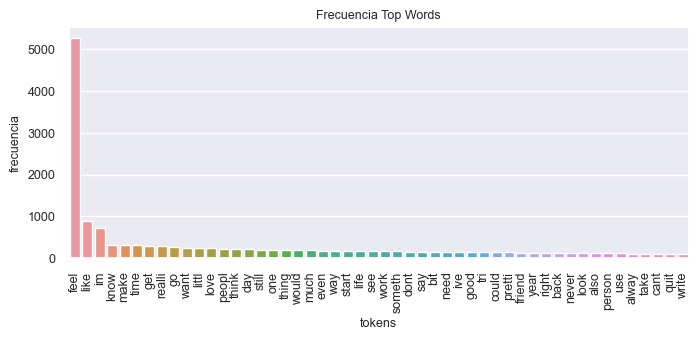

In [23]:
fig, ax = plt.subplots(figsize=(8,3),nrows=1)
ax.set_title('Frecuencia Top Words',fontsize=9)
sns.barplot(x=[w[0] for w in top_words], y=[w[1] for w in top_words])
ax.set_xlabel("tokens",fontsize=9)
ax.set_ylabel("frecuencia",fontsize=9)
ax.tick_params(axis='both', which='major', labelsize=9)
plt.xticks(rotation=90)
plt.show()

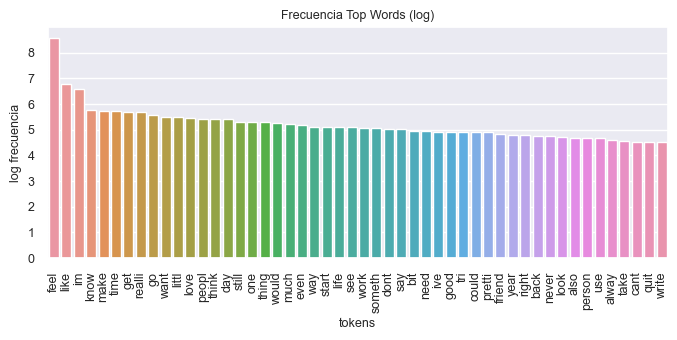

In [25]:
# Lo mismo pero con el log de la frecuencia
fig, ax = plt.subplots(figsize=(8,3),nrows=1)
ax.set_title('Frecuencia Top Words (log)',fontsize=9)
sns.barplot(x=[w[0] for w in top_words], y=np.log([w[1] for w in top_words]))
ax.set_xlabel("tokens",fontsize=9)
ax.set_ylabel("log frecuencia",fontsize=9)
ax.tick_params(axis='both', which='major', labelsize=9)
plt.xticks(rotation=90)
plt.show()

La ley de Zipf establece que la frecuencia de n-ésima palabra más frecuente se puede aproximar como $\frac{1}{n^a}$, donde $a$ es un número cercano a 1. Específicamente, en el procesamiento de texto, se utiliza para modelar la distribución de frecuencia de las palabras en un texto.

En el primer gráfico, es posible observar un comportamiento similar al predicho por la ley de Zipf, con las primeras palabras teniendo una frecuencia exponencialmente mayor que las palabras subsecuentes. El segundo gráfico ilustra esto un poco mejor - se puede ver que el logaritmo de la frecuencia decae con un patrón cercano a una recta de pendiente negativa, que es justamente lo que predice la ley de Zipf.

*   Averigue en qué consiste la técnica denominada *Random Oversampling* e implemente un generador que permita aplicarla sin comprometer el espacio en disco.

In [19]:
from imblearn.keras import balanced_batch_generator
from imblearn.over_sampling import RandomOverSampler

In [20]:
vector_generator, steps_per_epoch = balanced_batch_generator(train_vectors, y_train, sampler=RandomOverSampler(), batch_size=32, random_state=42)

Random oversampling es una técnica utilizada para compensar el desbalance entre clases en un dataset. La idea detrás de esta técnica es aumentar artificialmente el número de instancias de las clases con menos datos, para equilibrar la proporción entre clases. Funciona duplicando al azar elementos en el conjunto minoritario hasta igualarlo al tamaño de los conjuntos mayoritarios.



*   Proponga y motive un método diferente del anterior para enfrentar el problema del desbalance. ¿Qué ventaja y qué desventaja se espera respecto del anterior?



Es posible igualar las clases también eliminando elementos de las clases mayoritarias (Random Undersampling), lo que tiene la gran desventaja de hacer que se pierdan datos de entrenamiento, pero no posee los riesgos de la técnica de Oversampling de que se produzca sobreajuste al estar replicando muchas veces los mismos datos.

Una tercera vía sería hacer un equilibrio entre estos dos métodos, buscando que no se repliquen en exceso los datos mediante Oversampling, y tampoco perder demasiados datos al hacer Undersampling.

# 4. FNN

Comenzaremos utilizando una red completamente conectada. Como estas redes no tienen preferencias por el orden de los atributos en el dato de entrada combinaremos este modelo con la representación vectorial clásica del texto.

## Modelo


*   ¿Cuántas capas, neuronas y parámetros tiene la FNN definida más abajo?

In [24]:
from tensorflow.keras.layers import Dense

def FNN(num_words=5000):
  input = keras.Input(shape=(num_words))
  hidden = Dense(50, activation='relu')(input)
  hidden = Dense(20, activation='relu')(hidden)
  output = Dense(len(emotions),activation="softmax")(hidden)
  model_dense = tf.keras.Model(inputs=input, outputs=output)
  return model_dense


In [25]:
modelo_denso = FNN(num_words=5000)
modelo_denso.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5000)]            0         
                                                                 
 dense (Dense)               (None, 50)                250050    
                                                                 
 dense_1 (Dense)             (None, 20)                1020      
                                                                 
 dense_2 (Dense)             (None, 6)                 126       
                                                                 
Total params: 251,196
Trainable params: 251,196
Non-trainable params: 0
_________________________________________________________________


La red posee una capa de input y 3 capas densas. Estas tienen 5000, 50, 20 y 6 neuronas respectivamente, lo que lleva a un total 251,196 parámetros entrenables.

*   ¿Es apropiado medir el desempeño de la red usando exactitud (accuracy) en este problema? ¿Qué ventaja tendría monitorear el entrenamiento usando Macro F1?

In [30]:
import tensorflow_addons as tfa
METRICS = [
      tf.metrics.BinaryAccuracy(name='accuracy'),
      tfa.metrics.F1Score(name='F1',average='macro',num_classes=len(emotions))
]

c:\Users\joaco\anaconda3\envs\Python39\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


El problema de usar binary accuracy es que, dado que los vectores de salida están codificados como one-hot, tan sólo prediciendo ceros la red podría lograr una alta precisión; es decir, la métrica no discrimina cuándo se está logrando predecir correctamente "ceros" y "unos". Esto es lo que logra solucionar la métrica F1, que toma en cuenta cuándo el modelo logra predecir clases (o "unos") correctamente, lo que se acerca considerablemente más a lo que se quiere medir como eficacia del modelo.

## Entrenamiento Básico

*   Entrene la FNN definida anteriormente usando la representación TF básica (mode='freq') sin emplear técnicas que traten el desbalance de clases. Explique brevemente en qué consiste la técnica denominada *Early Stopping* y empléela utilizando una métrica apropiada para este problema. Para protegerse de eventuales incovenientes computacionales, averigue también cómo guardar *checkpoints* que le permitan re-iniciar el entrenamiento desde algún punto anterior.

In [29]:
from tensorflow.keras.optimizers import SGD, Adam

modelo_denso = FNN(num_words=5000)
opt =  Adam()

modelo_denso.compile(loss='categorical_crossentropy', metrics=METRICS, optimizer=opt)

checkpoint_path = 'FNN_checkpoints/FNN.{epoch:02d}-{val_F1:.4f}.h5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,save_best_only=True,monitor='val_F1',mode='max')

es = tf.keras.callbacks.EarlyStopping(monitor='val_F1', patience=3, restore_best_weights=True, mode='max')
historial_FF = modelo_denso.fit(train_vectors, y_train, batch_size=32, epochs=40, verbose=2, validation_data=(val_vectors, y_val),callbacks=[es,cp_callback])


Epoch 1/40
157/157 - 1s - loss: 1.6331 - accuracy: 0.8333 - F1: 0.0855 - val_loss: 1.5592 - val_accuracy: 0.8333 - val_F1: 0.0860 - 1s/epoch - 7ms/step
Epoch 2/40
157/157 - 0s - loss: 1.3946 - accuracy: 0.8508 - F1: 0.2050 - val_loss: 1.3405 - val_accuracy: 0.8693 - val_F1: 0.2254 - 313ms/epoch - 2ms/step
Epoch 3/40
157/157 - 0s - loss: 1.0572 - accuracy: 0.9064 - F1: 0.2805 - val_loss: 1.1040 - val_accuracy: 0.8917 - val_F1: 0.3154 - 311ms/epoch - 2ms/step
Epoch 4/40
157/157 - 0s - loss: 0.7888 - accuracy: 0.9229 - F1: 0.4891 - val_loss: 0.9666 - val_accuracy: 0.8953 - val_F1: 0.4448 - 304ms/epoch - 2ms/step
Epoch 5/40
157/157 - 0s - loss: 0.5689 - accuracy: 0.9404 - F1: 0.6701 - val_loss: 0.8309 - val_accuracy: 0.9108 - val_F1: 0.5523 - 309ms/epoch - 2ms/step
Epoch 6/40
157/157 - 0s - loss: 0.3829 - accuracy: 0.9667 - F1: 0.7476 - val_loss: 0.7488 - val_accuracy: 0.9194 - val_F1: 0.5847 - 320ms/epoch - 2ms/step
Epoch 7/40
157/157 - 0s - loss: 0.2629 - accuracy: 0.9795 - F1: 0.7756 - 

EarlyStopping es una técnica para evitar un sobreajuste de la red, que detiene el entrenamiento cuando no se ha logrado mejorar alguna métrica (en este caso, la métrica F1 en el conjunto de validación) tras una cierta cantidad de épocas (en este caso, 3).

*   Estudie las curvas de aprendizaje del modelo anterior. ¿Parecen suficientes las épocas de entrenamiento realizadas? ¿Observa overfitting? ¿Hay correlación entre el comportamiento observado en exactitud versus Macro F1?

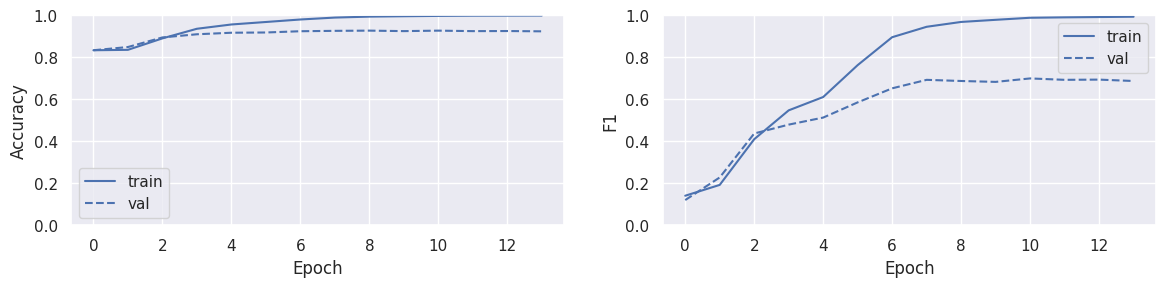

In [29]:
mpl.rcParams['figure.figsize'] = (14, 6)
plot_metrics(historial_FF)

Para este caso, la cantidad de épocas pareciera ser suficiente, ya que no se observa una mejora importante de la métrica val_F1 a partir de la época 7. Se puede ver que sí existe overfitting, ya que el F1 sobre el conjunto de entrenamiento logra llegar a una magnitud cercana a 1, y pareciera mantenerse en una curva ascendente estable; mientras que, en la curva de validación, se puede ver que el F1 se estanca en un valor bastante menor e incluso oscila, tendiendo a descender, en la medida que las épocas avanzan. Esto también puede ser observado (en peor detalle) en el gráfico con la métrica de Binary Accuracy - la exactitud también tiende a estancarse en un valor menor para el conjunto de validación, llegando la de entrenamiento a un valor cercano a 1, por lo que la correlación entre ambos gráficos es alta.


*   ¿Se predicen todas las clases igual de bien en el conjunto de pruebas? ¿Cuál es la clase que se confunde más y con qué otras clases?



157/157 [==============================] - 0s 2ms/step

ACCURACY:  0.787

Confusion Matrix



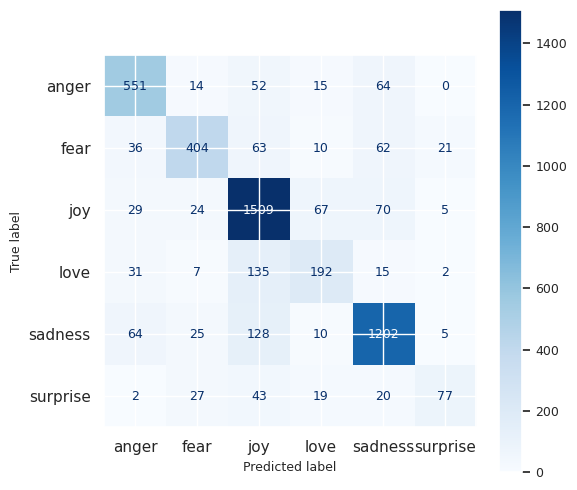


Classification Report

              precision    recall  f1-score   support

       anger       0.77      0.79      0.78       696
        fear       0.81      0.68      0.74       596
         joy       0.78      0.89      0.83      1704
        love       0.61      0.50      0.55       382
     sadness       0.84      0.84      0.84      1434
    surprise       0.70      0.41      0.52       188

    accuracy                           0.79      5000
   macro avg       0.75      0.68      0.71      5000
weighted avg       0.78      0.79      0.78      5000



In [30]:
y_pred = modelo_denso.predict(test_vectors)
y_pred = y_pred.argmax(axis=1)
get_detailed_report(le_test,y_pred,le.classes_)

Los resultados muestran que la clase "love" y "surprise" tienden a ser más difíciles de predecir que el resto de las clases, al ser las que tienen un menor "f1-score" que el resto de las clases.<br>
Las que más se confunden son "joy" y "love", que se puede ver en que para la etiqueta real de "love", las predicciones están divididas casi equitativamente entre las dos clases. También parece haber una tendencia a confundir "surprise" y "joy", aunque en este caso, la clase "surprise" completa pareciera tender a ser confundida con muchas de las otras clases.

## Entrenamiento usando Datos Balanceados


*   Utilice la técnica de balanceo que se le propone en la sección 3 y determine si logra producir mejores resultados. Analice las curvas y métricas adecuadas al elaborar su respuesta.

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam

modelo_denso = FNN(num_words=5000)
opt =  Adam()

modelo_denso.compile(loss='categorical_crossentropy', metrics=METRICS, optimizer=opt)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_F1',factor=0.2,patience=5, min_lr=0.001)

checkpoint_path = 'FNN_checkpoints/FNN_Balanceada.{epoch:02d}-{val_F1:.4f}.h5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,save_best_only=True,monitor='val_F1',mode='max')

es = tf.keras.callbacks.EarlyStopping(monitor='val_F1', patience=5, restore_best_weights=True, mode='max')
historial_FF = modelo_denso.fit(vector_generator, steps_per_epoch=steps_per_epoch, epochs=40, verbose=2, validation_data=(val_vectors, y_val),callbacks=[es, cp_callback, reduce_lr])


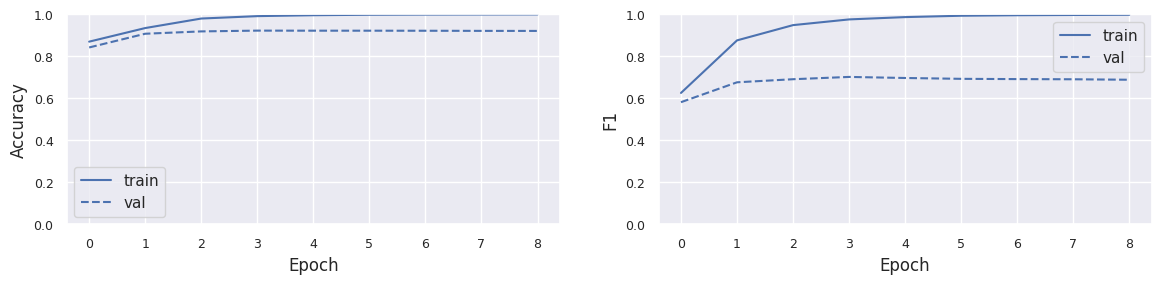

In [32]:
mpl.rcParams['figure.figsize'] = (14, 6)
plot_metrics(historial_FF)

157/157 [==============================] - 0s 2ms/step

ACCURACY:  0.7728

Confusion Matrix



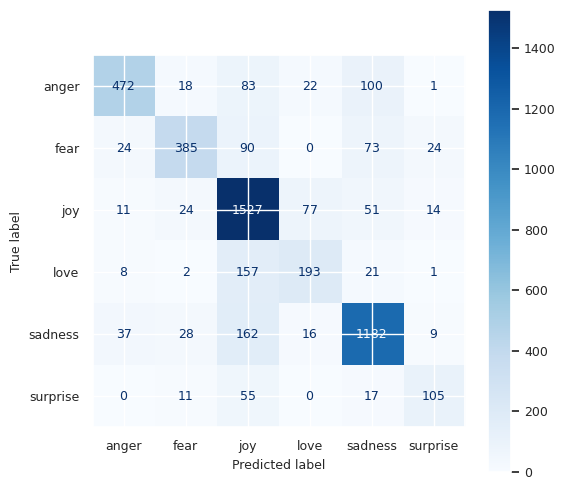


Classification Report

              precision    recall  f1-score   support

       anger       0.86      0.68      0.76       696
        fear       0.82      0.65      0.72       596
         joy       0.74      0.90      0.81      1704
        love       0.63      0.51      0.56       382
     sadness       0.82      0.82      0.82      1434
    surprise       0.68      0.56      0.61       188

    accuracy                           0.77      5000
   macro avg       0.76      0.68      0.71      5000
weighted avg       0.78      0.77      0.77      5000



In [33]:
y_pred = modelo_denso.predict(test_vectors)
y_pred = y_pred.argmax(axis=1)
get_detailed_report(le_test,y_pred,le.classes_)

Pareciera que el balanceo de clases mediante "Random oversampling" no produce grandes diferencias en cuanto al máximo f1-score que alcanza el entrenamiento y las clases que más se confunden. La mayor diferencia observable es que se requirieron menos épocas para alcanzar el máximo f1_score, y el score inicial fue mayor también.

## Propuesta


*   Implemente el método alternativo que sugirió en la sección 3 para tratar el problema del desbalance y evalúe su efectividad.

In [32]:
test_tweet ="This is so so bad man"
tweet_vector = TF_tokenizer.texts_to_matrix([test_tweet], mode='freq')
prediction = le.inverse_transform(modelo_denso.predict(tweet_vector).argmax(axis=1))
print("TEST TWEET: ",test_tweet)
print("PREDICTION: ",prediction)

1/1 [==============================] - 0s 57ms/step
TEST TWEET:  This is so so bad man
PREDICTION:  ['sadness']


## Análisis


*  Investigue al menos una de los siguientes interrogantes:

1.   ¿Se empeora o mejora el desempeño si no se aplica stemming para pre-procesar los textos?
2.   ¿Se empeora o mejora el desempeño si no se filtran stopwords al pre-procesar los textos?
3.   ¿Se empeora o mejora el desempeño al reducir/aumentar el tamaño del vocabulario? ¿Logra el desempeño sobre los datos de validación anticipar el efecto que se observará sobre el conjunto de pruebas?




In [36]:
nonstemmed_train = [preprocess(tweet, stemming=False) for tweet in train_tweets]
nonstemmed_val = [preprocess(tweet, stemming=False) for tweet in val_tweets]
nonstemmed_test = [preprocess(tweet, stemming=False) for tweet in test_tweets]


train_vectors = TF_tokenizer.texts_to_matrix(nonstemmed_train, mode='freq')
val_vectors = TF_tokenizer.texts_to_matrix(nonstemmed_val, mode='freq')
test_vectors = TF_tokenizer.texts_to_matrix(nonstemmed_test, mode='freq')


In [37]:
from tensorflow.keras.optimizers import SGD, Adam

modelo_denso = FNN(num_words=5000)
opt =  Adam()

modelo_denso.compile(loss='categorical_crossentropy', metrics=METRICS, optimizer=opt)

checkpoint_path = 'FNN_checkpoints/FNN.{epoch:02d}-{val_F1:.4f}.h5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,save_best_only=True,monitor='val_F1',mode='max')

es = tf.keras.callbacks.EarlyStopping(monitor='val_F1', patience=3, restore_best_weights=True, mode='max')
historial_FF = modelo_denso.fit(train_vectors, y_train, batch_size=32, epochs=40, verbose=2, validation_data=(val_vectors, y_val),callbacks=[es,cp_callback])

Epoch 1/40
157/157 - 1s - loss: 1.6290 - accuracy: 0.8791 - F1: 0.4725 - val_loss: 1.5838 - val_accuracy: 0.8333 - val_F1: 0.1468 - 899ms/epoch - 6ms/step
Epoch 2/40
157/157 - 0s - loss: 1.4980 - accuracy: 0.8352 - F1: 0.1702 - val_loss: 1.5271 - val_accuracy: 0.8393 - val_F1: 0.1721 - 310ms/epoch - 2ms/step
Epoch 3/40
157/157 - 0s - loss: 1.3691 - accuracy: 0.8551 - F1: 0.2047 - val_loss: 1.4694 - val_accuracy: 0.8481 - val_F1: 0.1830 - 308ms/epoch - 2ms/step
Epoch 4/40
157/157 - 0s - loss: 1.2259 - accuracy: 0.8716 - F1: 0.2740 - val_loss: 1.4425 - val_accuracy: 0.8488 - val_F1: 0.2534 - 308ms/epoch - 2ms/step
Epoch 5/40
157/157 - 0s - loss: 1.0924 - accuracy: 0.8848 - F1: 0.3771 - val_loss: 1.4523 - val_accuracy: 0.8505 - val_F1: 0.2853 - 312ms/epoch - 2ms/step
Epoch 6/40
157/157 - 0s - loss: 0.9846 - accuracy: 0.8952 - F1: 0.4472 - val_loss: 1.4856 - val_accuracy: 0.8485 - val_F1: 0.3090 - 313ms/epoch - 2ms/step
Epoch 7/40
157/157 - 0s - loss: 0.8982 - accuracy: 0.9030 - F1: 0.5132

Los resultados muestran que no utilizar stemming disminuye notoriamente el desempeño del modelo. El valor de val_F1 máximo es de 0.3262, lo que es menos de la mitad de lo que se logró con los datos que si fueron preprocesados con stemming. Esto muestra lo efectivo que es stemming como forma de facilitar la detección de patrones en el texto. 

# 5. Textos como Secuencias

Preparándonos para entrenar modelos más avanzados, representaremos el texto como una secuencia de símbolos o *tokens*. Estos elementos son típicamente palabras, pero podrían también ser fragmentos de palabras o combinaciones de palabras (n-grams).

In [33]:
#ejecutar sólo si se han creado anteriormente para liberar memoria
del train_vectors
del val_vectors
del test_vectors

Antes de obtener procesar los textos para extraer secuencias, somos libres de aplicar todos o algunos de los métodos de limpieza considerados anteriormente. A no ser que se especifique lo contrario, usaremos por defecto la representación que se encuentra descomentada más abajo.

In [27]:
#aplica todos los pasos de limpieza ya considerados
#cleaned_train = [preprocess(tweet,cleaning=True,stopwords=True,stemming=True) for tweet in train_tweets]
#cleaned_val = [preprocess(tweet,cleaning=True,stopwords=True,stemming=True) for tweet in val_tweets]
#cleaned_test = [preprocess(tweet,cleaning=True,stopwords=True,stemming=True) for tweet in test_tweets]

In [21]:
#evitar hacer stemming (por defecto se usa este)
cleaned_train = [preprocess(tweet,cleaning=True,stopwords=True,stemming=False) for tweet in train_tweets]
cleaned_val = [preprocess(tweet,cleaning=True,stopwords=True,stemming=False) for tweet in val_tweets]
cleaned_test = [preprocess(tweet,cleaning=True,stopwords=True,stemming=False) for tweet in test_tweets]

In [86]:
#evitar stemming y filtrado de stopwords
#cleaned_train = [preprocess(tweet,cleaning=True,stopwords=False,stemming=False) for tweet in train_tweets]
#cleaned_val = [preprocess(tweet,cleaning=True,stopwords=False,stemming=False) for tweet in val_tweets]
#cleaned_test = [preprocess(tweet,cleaning=True,stopwords=False,stemming=False) for tweet in test_tweets]

Para comparar de manera "justa" con los métodos anteriores, utilizaremos el mismo tamaño de vocabulario.

In [45]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

n_max_words = 5000

Seq_tokenizer = Tokenizer(num_words=n_max_words)
Seq_tokenizer.fit_on_texts(cleaned_train)

train_sequences = Seq_tokenizer.texts_to_sequences(cleaned_train)
val_sequences = Seq_tokenizer.texts_to_sequences(cleaned_val)
test_sequences = Seq_tokenizer.texts_to_sequences(cleaned_test)


*   Estudie cómo se distribuye el largo de las secuencias obtenidas de manera de estandarizar correctamente su longitud. Este es un paso requerido por la mayoría de las librerías.

In [46]:
print(train_tweets[10], len(train_tweets[10]))
print(cleaned_train[10], len(cleaned_train[10]))
print(train_sequences[10], len(train_sequences[10]))
print(np.mean([len(seq) for seq in train_sequences]))
print(np.quantile([len(seq) for seq in train_sequences],0.99))

i do drink plus people usually notice this way before i do usually that im talking very fast or loud or zipping around everywhere but in the end it feels physically very uncomfortable nearly painful 198
i do drink plus people usually notice this way before i do usually that im talking very fast or loud or zipping around everywhere but in the end it feels physically very uncomfortable nearly painful 198
[1, 37, 1479, 1220, 57, 323, 811, 24, 83, 166, 1, 37, 323, 9, 18, 375, 42, 1104, 32, 2013, 32, 3627, 135, 1330, 22, 11, 5, 181, 12, 138, 763, 42, 497, 1480, 1693] 35
18.3958
51.0


Se estandarizará el largo de las secuencias a un número mayor que el que tiene el 99% de las secuencias (en este caso el percentil 99 es de largo 24).


*  A partir de los resultados de su análisis, proponga un valor L para el largo máximo de secuencia aplicando padding para estandarizar la longitud de los textos más cortos. ¿Qué sucede con los textos cuyo largo es mayor que L?

In [47]:
# Para comparar una secuencia antes de padear y despues de padear
max_text_length = 25
for secuencia in train_sequences:
    if len(secuencia) > max_text_length:
        print(secuencia, len(secuencia))
        indice_sobre_max = train_sequences.index(secuencia)
        print(indice_sobre_max)
        break

[18, 355, 9, 24, 20, 93, 4, 1006, 13, 261, 2010, 1477, 25, 19, 22, 1, 322, 39, 24, 222, 7, 42, 1219, 25, 54, 14, 52, 2011, 2012, 19, 1, 106, 4, 201, 3, 219, 12, 47, 8, 19] 40
8


In [48]:
max_text_length = 25
train_sequences = pad_sequences(train_sequences, maxlen=max_text_length)
val_sequences = pad_sequences(val_sequences, maxlen=max_text_length)
test_sequences = pad_sequences(test_sequences, maxlen=max_text_length)

In [49]:
# Comprobar que pasó con la secuencia después de padear
print(train_sequences[indice_sobre_max], len(train_sequences[indice_sobre_max]))

[   1  322   39   24  222    7   42 1219   25   54   14   52 2011 2012
   19    1  106    4  201    3  219   12   47    8   19] 25


Los textos cuyo largo es mayor que L son truncados, eliminando los primeros elementos de la secuencia hasta quedar en el largo especificado.

In [37]:
wcounts = list(Seq_tokenizer.word_counts.items())
wcounts.sort(key=lambda x: x[1], reverse=True)
top_words = wcounts[:n_max_words]
top_words = [w[0] for w in top_words]
print(top_words)

['feel', 'feeling', 'like', 'im', 'really', 'know', 'time', 'little', 'people', 'get', 'still', 'would', 'one', 'much', 'think', 'want', 'even', 'life', 'make', 'something', 'way', 'day', 'dont', 'things', 'bit', 'ive', 'going', 'could', 'pretty', 'love', 'good', 'see', 'go', 'need', 'back', 'never', 'right', 'work', 'also', 'say', 'always', 'cant', 'many', 'made', 'around', 'feels', 'quite', 'feelings', 'today', 'makes', 'without', 'person', 'well', 'new', 'every', 'didnt', 'got', 'though', 'someone', 'better', 'lot', 'getting', 'happy', 'less', 'year', 'sure', 'http', 'help', 'everything', 'days', 'anything', 'last', 'enough', 'started', 'world', 'friends', 'felt', 'find', 'first', 'start', 'end', 'said', 'left', 'take', 'away', 'actually', 'trying', 'long', 'others', 'bad', 'stressed', 'ever', 'us', 'href', 'ill', 'making', 'home', 'lost', 'may', 'try', 'done', 'look', 'rather', 'often', 'kind', 'able', 'since', 'come', 'family', 'keep', 'thought', 'years', 'yet', 'next', 'thing', '

## Balanceo

La nueva representación obtenida no está exenta de los problemas de desbalance que hemos observado. Por este motivo, vale la pena evaluar el beneficio de utilizar alguna técnica de balanceo como la que definimos en la sección 3.

In [38]:
from imblearn.keras import balanced_batch_generator
from imblearn.over_sampling import RandomOverSampler

In [32]:
sequence_generator, steps_per_epoch = balanced_batch_generator(train_sequences, y_train, sampler=RandomOverSampler(), batch_size=32, random_state=42)

*   Discuta la aplicabilidad de la técnica alternativa que propuso en la sección 3 a la nueva representación de los textos.

La aplicabilidad de utilizar tanto Random Oversampling como Undersampling no cambia según la representación utilizada, ya que esto se basa sólo en aumentar o disminuir los datos sin tomar en consideración cómo estos están representados.

# 5. RNN

Como hemos discutido, las redes neuronales recurrentes son modelos especializados en aprendizaje sobre secuencias. Sin embargo, estos modelos pueden verse afectados por el fenómeno de desvanecimiento o explosión de los gradientes cuando se entrenan sobre secuencias muy largas. Los modelos basados en compuertas como las LSTM o GRU permiten atenuar este problema.

*   Defina una LSTM con dos capas ocultas recurrentes y una capa oculta antes de la salida. Para poder procesar tokens discretos averigue qué hace una capa de tipo *Embedding* e incorpórela justo antes de la primera capa recurrente. Para determinar el número de celdas a utilizar considere el largo de las secuencias a procesar. Tenga la precaución de especificar un tamaño de entrada consistente con el que utilizó en la sección 5 al representar los textos como secuencias.

In [23]:
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, SpatialDropout1D

emd_dim = 32

def RNN():
  input_sequence = keras.Input(shape=(max_text_length),dtype="int64")
  embedded_sequence = Embedding(n_max_words, emd_dim)(input_sequence)
  embedded_sequence = SpatialDropout1D(0.25)(embedded_sequence)
  #recurrent = LSTM(25,return_sequences=False)(embedded_sequence)
  recurrent = LSTM(25,return_sequences=True)(embedded_sequence)
  recurrent = SpatialDropout1D(0.25)(recurrent)
  recurrent = LSTM(25,return_sequences=False)(recurrent)
  recurrent = Dense(25, activation='relu')(recurrent)
  sentiment = Dense(len(emotions),activation="softmax")(recurrent)
  modelo_recurrente = keras.Model(input_sequence, sentiment)
  return modelo_recurrente

### Entrenamiento Básico

*   Entrene el modelo sin emplear ninguna técnica de balanceo, determinando si logra mejorar el desempeño obtenido con el modelo denso tradicional. Además de comparar la efectividad en la tarea a resolver, comente sobre la mayor o menor eficiencia computacional del modelo recurrente y la mayor o menor cantidad de parámetros a entrenar. ¿Qué capa contribuye con la mayor cantidad de parámetros entrenables? ¿Cómo podría reducirse la complejidad de esa capa?


In [29]:
import tensorflow_addons as tfa
METRICS = [
      tf.metrics.BinaryAccuracy(name='accuracy'),
      tfa.metrics.F1Score(name='F1',average='macro',num_classes=len(emotions))
]

c:\Users\joaco\anaconda3\envs\MyEnv\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [42]:
from tensorflow.keras.optimizers import SGD, Adam

modelo_recurrente = RNN()
modelo_recurrente.summary()

opt = Adam()
modelo_recurrente.compile(loss='categorical_crossentropy', metrics=METRICS, optimizer=opt)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 25)]              0         
                                                                 
 embedding (Embedding)       (None, 25, 32)            160000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 25, 32)           0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 25, 25)            5800      
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 25, 25)           0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 25)                5100

La capa que más parámetros contribuye es la capa de Embedding, que es la que se encarga de convertir las secuencias de palabras en vectores que existen en un espacio n-dimensional (con n=32, en este caso). Se podría reducir la complejidad de esta capa reduciendo la dimensionalidad de los vectores generados,  reduciendo el largo máximo de las secuencias o disminuyendo la cantidad de palabras que extrae el Tokenizer.

In [44]:
checkpoint_path = 'LSTM_checkpoints/LSTM.{epoch:02d}-{val_F1:.4f}.h5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,save_best_only=True,monitor='val_F1',mode='max')
es = tf.keras.callbacks.EarlyStopping(monitor='val_F1', patience=5, restore_best_weights=True, mode='max')
history_recurrente = modelo_recurrente.fit(train_sequences, y_train, epochs=40, validation_data=(val_sequences, y_val), callbacks=[es,cp_callback])


Epoch 1/40
157/157 [==============================] - 2s 10ms/step - loss: 0.8424 - accuracy: 0.9049 - F1: 0.4726 - val_loss: 0.8949 - val_accuracy: 0.9043 - val_F1: 0.4787
Epoch 2/40
157/157 [==============================] - 2s 10ms/step - loss: 0.5092 - accuracy: 0.9397 - F1: 0.6198 - val_loss: 0.8317 - val_accuracy: 0.9153 - val_F1: 0.5576
Epoch 3/40
157/157 [==============================] - 2s 10ms/step - loss: 0.3489 - accuracy: 0.9623 - F1: 0.7124 - val_loss: 0.8403 - val_accuracy: 0.9239 - val_F1: 0.5965
Epoch 4/40
157/157 [==============================] - 2s 10ms/step - loss: 0.2472 - accuracy: 0.9725 - F1: 0.7586 - val_loss: 0.9259 - val_accuracy: 0.9193 - val_F1: 0.6232
Epoch 5/40
157/157 [==============================] - 2s 10ms/step - loss: 0.2103 - accuracy: 0.9765 - F1: 0.8270 - val_loss: 0.8739 - val_accuracy: 0.9269 - val_F1: 0.6749
Epoch 6/40
157/157 [==============================] - 2s 10ms/step - loss: 0.1642 - accuracy: 0.9813 - F1: 0.8813 - val_loss: 0.9116 - 

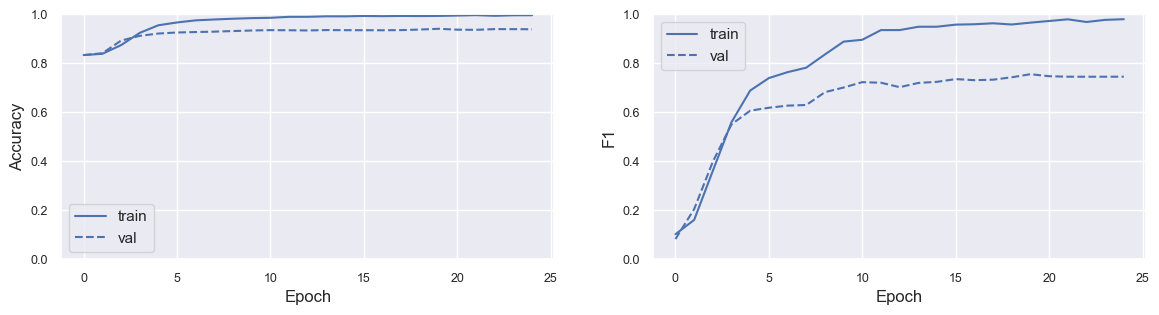

In [105]:
mpl.rcParams['figure.figsize'] = (14, 7)
plot_metrics(history_recurrente)

157/157 [==============================] - 1s 2ms/step

ACCURACY:  0.8322

Confusion Matrix



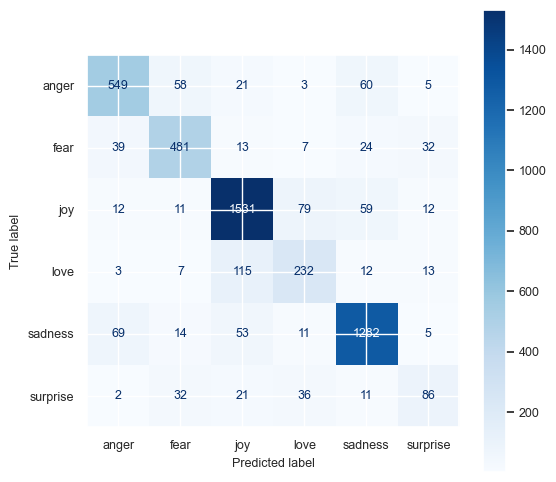


Classification Report

              precision    recall  f1-score   support

       anger       0.81      0.79      0.80       696
        fear       0.80      0.81      0.80       596
         joy       0.87      0.90      0.89      1704
        love       0.63      0.61      0.62       382
     sadness       0.89      0.89      0.89      1434
    surprise       0.56      0.46      0.50       188

    accuracy                           0.83      5000
   macro avg       0.76      0.74      0.75      5000
weighted avg       0.83      0.83      0.83      5000



In [106]:
y_pred = modelo_recurrente.predict(test_sequences)
y_pred = y_pred.argmax(axis=1)
get_detailed_report(le_test,y_pred,le.classes_)

## Entrenamiento usando Datos Balanceados

*   Entrene el modelo recurrente usando alguna técnica para lidiar con el desbalance de clases. Comparare la efectividad de este método con los resultados obtenidos anteriormente.

In [30]:
from tensorflow.keras.optimizers import SGD, Adam

modelo_recurrente = RNN()
modelo_recurrente.summary()

opt = Adam()
modelo_recurrente.compile(loss='categorical_crossentropy', metrics=METRICS, optimizer=opt)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 25)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 25, 32)            160000    
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 25, 32)           0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 25, 25)            5800      
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 25, 25)           0         
 lDropout1D)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 25)                5100

In [33]:
checkpoint_path = 'LSTM_checkpoints/LSTM_balanceada.{epoch:02d}-{val_F1:.4f}.h5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,save_best_only=True,monitor='val_F1',mode='max')
es = tf.keras.callbacks.EarlyStopping(monitor='val_F1', patience=5, restore_best_weights=True, mode='max')
history_recurrente = modelo_recurrente.fit(sequence_generator, steps_per_epoch=steps_per_epoch, epochs=40, validation_data=(val_sequences, y_val), callbacks=[es])

Epoch 1/40
321/321 [==============================] - 6s 10ms/step - loss: 1.4527 - accuracy: 0.8465 - F1: 0.3617 - val_loss: 1.2525 - val_accuracy: 0.8366 - val_F1: 0.4231
Epoch 2/40
321/321 [==============================] - 3s 8ms/step - loss: 0.7218 - accuracy: 0.8988 - F1: 0.6889 - val_loss: 1.0958 - val_accuracy: 0.8572 - val_F1: 0.6010
Epoch 3/40
321/321 [==============================] - 3s 8ms/step - loss: 0.4759 - accuracy: 0.9396 - F1: 0.8165 - val_loss: 1.0437 - val_accuracy: 0.8866 - val_F1: 0.6481
Epoch 4/40
321/321 [==============================] - 3s 8ms/step - loss: 0.3215 - accuracy: 0.9628 - F1: 0.8872 - val_loss: 0.9460 - val_accuracy: 0.9112 - val_F1: 0.7259
Epoch 5/40
321/321 [==============================] - 3s 8ms/step - loss: 0.2066 - accuracy: 0.9784 - F1: 0.9344 - val_loss: 0.8958 - val_accuracy: 0.9232 - val_F1: 0.7525
Epoch 6/40
321/321 [==============================] - 3s 8ms/step - loss: 0.1504 - accuracy: 0.9842 - F1: 0.9520 - val_loss: 0.8762 - val_a

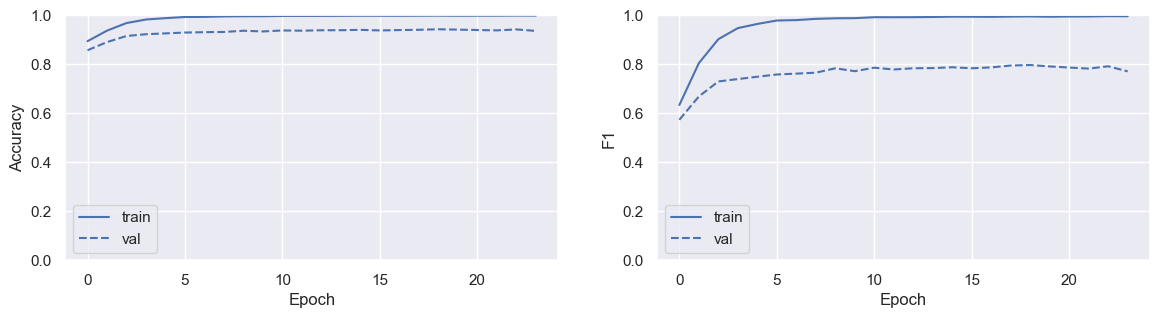

In [54]:
mpl.rcParams['figure.figsize'] = (14, 7)
plot_metrics(history_recurrente)

In [127]:
y_pred = modelo_recurrente.predict(test_sequences)
y_pred = y_pred.argmax(axis=1)
print(le_test.shape)
print(y_pred.shape)

157/157 [==============================] - 1s 2ms/step
(5000,)
(5000,)



ACCURACY:  0.8202

Confusion Matrix



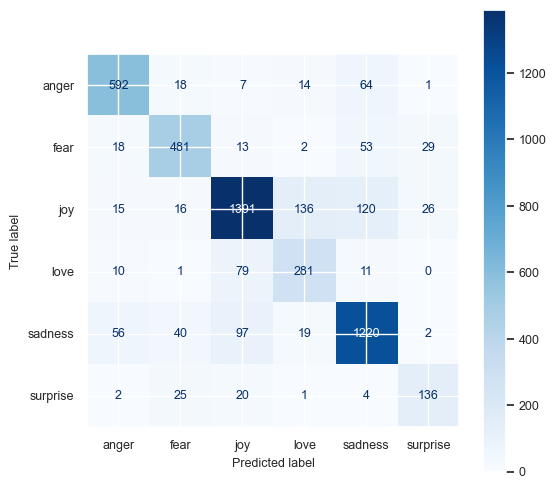


Classification Report

              precision    recall  f1-score   support

       anger       0.85      0.85      0.85       696
        fear       0.83      0.81      0.82       596
         joy       0.87      0.82      0.84      1704
        love       0.62      0.74      0.67       382
     sadness       0.83      0.85      0.84      1434
    surprise       0.70      0.72      0.71       188

    accuracy                           0.82      5000
   macro avg       0.78      0.80      0.79      5000
weighted avg       0.82      0.82      0.82      5000



In [128]:
get_detailed_report(le_test,y_pred,le.classes_)

El modelo recurrente es notoriamente mejor que el FNN utilizado anteriormente. Esto se puede ver, por un lado, en los f1-scores logrados en cada una de las clases - antes "love" y "surprise" tenían valores más cercanos a 0.6, y el resto de las clases ahora tienen todas un score superior a 0.8, lo que no ocurría antes. Por otro lado, la matriz de confusión muestra que las clases de "love" y "surprise" están mejor definidas que antes, ya que tienden a ser menos confundidas con otras clases comparado con el caso anterior.<br>
Considerar que esto requirió que se entrenara por más épocas, por lo que este modelo resulta más lento de entrenar, pero llega a ser mucho más efectivo.

## Análisis

*   Determine experimentalmente si eliminar el filtrado de stopwords al preprocesar el texto beneficia o no al modelo recurrente. *Hint: Para esto debe volver al punto 5 y activar los pasos de pre-procesamiento que correspondan. Tenga también la precaución de elegir el tamaño máximo de las secuencias de manera consiste con esta elección. Comente los resultados observados.*

In [96]:
# Código agregado para probar sin eliminar stopwords

cleaned_train_2 = [preprocess(tweet,cleaning=True,stopwords=False,stemming=False) for tweet in train_tweets]
cleaned_val_2 = [preprocess(tweet,cleaning=True,stopwords=False,stemming=False) for tweet in val_tweets]
cleaned_test_2 = [preprocess(tweet,cleaning=True,stopwords=False,stemming=False) for tweet in test_tweets]

n_max_words_2 = 6000 # aumentar este valor para considerar más palabras

Seq_tokenizer_2 = Tokenizer(num_words=n_max_words_2)
Seq_tokenizer_2.fit_on_texts(cleaned_train_2)

train_sequences_2 = Seq_tokenizer_2.texts_to_sequences(cleaned_train_2)
val_sequences_2 = Seq_tokenizer_2.texts_to_sequences(cleaned_val_2)
test_sequences_2 = Seq_tokenizer_2.texts_to_sequences(cleaned_test_2)

max_text_length_2 = 35
train_sequences_2 = pad_sequences(train_sequences_2, maxlen=max_text_length_2)
val_sequences_2 = pad_sequences(val_sequences_2, maxlen=max_text_length_2)
test_sequences_2 = pad_sequences(test_sequences_2, maxlen=max_text_length_2)

sequence_generator_2, steps_per_epoch_2 = balanced_batch_generator(train_sequences_2, y_train, sampler=RandomOverSampler(), batch_size=32, random_state=42)

emd_dim_2 = 32

def RNN_2():
  input_sequence = keras.Input(shape=(max_text_length_2),dtype="int64")
  embedded_sequence = Embedding(n_max_words_2, emd_dim_2)(input_sequence)
  embedded_sequence = SpatialDropout1D(0.25)(embedded_sequence)
  #recurrent = LSTM(25,return_sequences=False)(embedded_sequence)
  recurrent = LSTM(25,return_sequences=True)(embedded_sequence)
  recurrent = SpatialDropout1D(0.25)(recurrent)
  recurrent = LSTM(25,return_sequences=False)(recurrent)
  recurrent = Dense(25, activation='relu')(recurrent)
  sentiment = Dense(len(emotions),activation="softmax")(recurrent)
  modelo_recurrente = keras.Model(input_sequence, sentiment)
  return modelo_recurrente

modelo_recurrente_2 = RNN_2()
modelo_recurrente_2.compile(loss='categorical_crossentropy', metrics=METRICS, optimizer=opt)

checkpoint_path_2 = 'LSTM2_checkpoints/LSTM.{epoch:02d}-{val_F1:.4f}.h5'
cp_callback_2 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_2,save_weights_only=True,save_best_only=True,monitor='val_F1',mode='max')
es = tf.keras.callbacks.EarlyStopping(monitor='val_F1', patience=5, restore_best_weights=True, mode='max')
history_recurrente_2 = modelo_recurrente_2.fit(train_sequences_2, y_train, epochs=40, validation_data=(val_sequences_2, y_val), callbacks=[es,cp_callback_2])

Epoch 1/40
157/157 [==============================] - 5s 16ms/step - loss: 1.5922 - accuracy: 0.8333 - F1: 0.1244 - val_loss: 1.6016 - val_accuracy: 0.8333 - val_F1: 0.0833
Epoch 2/40
157/157 [==============================] - 2s 12ms/step - loss: 1.4756 - accuracy: 0.8332 - F1: 0.1598 - val_loss: 1.4017 - val_accuracy: 0.8338 - val_F1: 0.2255
Epoch 3/40
157/157 [==============================] - 2s 12ms/step - loss: 1.1359 - accuracy: 0.8423 - F1: 0.2954 - val_loss: 1.2707 - val_accuracy: 0.8362 - val_F1: 0.2413
Epoch 4/40
157/157 [==============================] - 2s 12ms/step - loss: 0.9603 - accuracy: 0.8729 - F1: 0.3564 - val_loss: 1.2267 - val_accuracy: 0.8724 - val_F1: 0.3592
Epoch 5/40
157/157 [==============================] - 2s 12ms/step - loss: 0.8154 - accuracy: 0.9038 - F1: 0.4185 - val_loss: 1.1384 - val_accuracy: 0.8875 - val_F1: 0.3795
Epoch 6/40
157/157 [==============================] - 2s 12ms/step - loss: 0.6843 - accuracy: 0.9197 - F1: 0.4783 - val_loss: 1.1086 - 

157/157 [==============================] - 1s 3ms/step

ACCURACY:  0.8228

Confusion Matrix



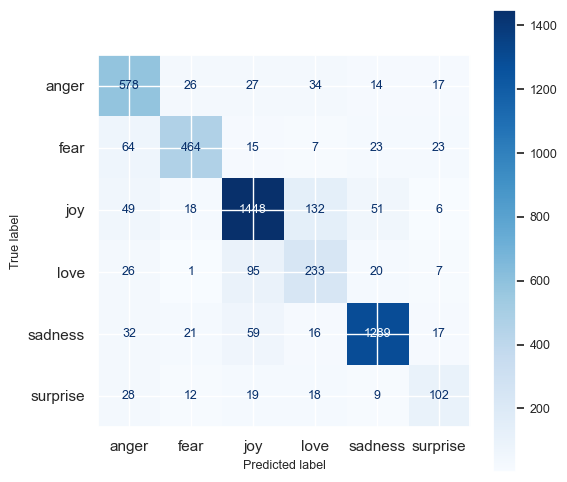


Classification Report

              precision    recall  f1-score   support

       anger       0.74      0.83      0.78       696
        fear       0.86      0.78      0.82       596
         joy       0.87      0.85      0.86      1704
        love       0.53      0.61      0.57       382
     sadness       0.92      0.90      0.91      1434
    surprise       0.59      0.54      0.57       188

    accuracy                           0.82      5000
   macro avg       0.75      0.75      0.75      5000
weighted avg       0.83      0.82      0.82      5000



In [97]:
y_pred = modelo_recurrente_2.predict(test_sequences_2)
y_pred = y_pred.argmax(axis=1)
get_detailed_report(le_test,y_pred,le.classes_)

Al no eliminar stopwords se puede ver que el rendimiento del modelo disminuye para la mayoría de las clases, siendo más notoria la disminución en la capacidad de predecir las clases de "love" y "surprise".

*   Determine si agregar bidireccionalidad al modelo recurrente mejora los resultados obtenidos.

In [81]:
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM
from tensorflow.keras.layers import Dense, Bidirectional
from tensorflow.keras.layers import Dropout, SpatialDropout1D

emd_dim = 32

def BiRNN():
  input_sequence = keras.Input(shape=(max_text_length),dtype="int64")
  embedded_sequence = Embedding(n_max_words, emd_dim)(input_sequence)
  embedded_sequence = SpatialDropout1D(0.25)(embedded_sequence)
  recurrent = Bidirectional(LSTM(25,return_sequences=True))(embedded_sequence)
  recurrent = SpatialDropout1D(0.25)(recurrent)
  recurrent = Bidirectional(LSTM(25,return_sequences=False))(recurrent)
  recurrent = Dense(25, activation='relu')(recurrent)
  sentiment = Dense(len(emotions),activation="softmax")(recurrent)
  modelo_recurrente = keras.Model(input_sequence, sentiment)
  return modelo_recurrente

In [82]:
from tensorflow.keras.optimizers import SGD, Adam

modelo_recurrente_bi = BiRNN()
modelo_recurrente_bi.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 25)]              0         
                                                                 
 embedding_5 (Embedding)     (None, 25, 32)            160000    
                                                                 
 spatial_dropout1d_10 (Spati  (None, 25, 32)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional (Bidirectiona  (None, 25, 50)           11600     
 l)                                                              
                                                                 
 spatial_dropout1d_11 (Spati  (None, 25, 50)           0         
 alDropout1D)                                                    
                                                           

In [88]:
opt = Adam()
modelo_recurrente_bi.compile(loss='categorical_crossentropy', metrics=METRICS, optimizer=opt)
es = tf.keras.callbacks.EarlyStopping(monitor='val_F1', patience=5, restore_best_weights=True, mode='max')
history_recurrente_bi = modelo_recurrente_bi.fit(sequence_generator, steps_per_epoch=steps_per_epoch, epochs=40, validation_data=(val_sequences, y_val), callbacks=[es])

Epoch 1/40
321/321 [==============================] - 38s 92ms/step - loss: 1.4109 - accuracy: 0.8816 - F1: 0.5277 - val_loss: 1.2861 - val_accuracy: 0.8360 - val_F1: 0.5297
Epoch 2/40
321/321 [==============================] - 5s 17ms/step - loss: 0.5009 - accuracy: 0.9417 - F1: 0.8186 - val_loss: 0.8908 - val_accuracy: 0.9034 - val_F1: 0.7004
Epoch 3/40
321/321 [==============================] - 7s 21ms/step - loss: 0.2378 - accuracy: 0.9745 - F1: 0.9217 - val_loss: 0.9010 - val_accuracy: 0.9116 - val_F1: 0.7259
Epoch 4/40
321/321 [==============================] - 7s 22ms/step - loss: 0.1495 - accuracy: 0.9839 - F1: 0.9508 - val_loss: 0.8947 - val_accuracy: 0.9229 - val_F1: 0.7499
Epoch 5/40
321/321 [==============================] - 9s 27ms/step - loss: 0.1130 - accuracy: 0.9883 - F1: 0.9642 - val_loss: 0.9637 - val_accuracy: 0.9220 - val_F1: 0.7461
Epoch 6/40
321/321 [==============================] - 7s 23ms/step - loss: 0.0869 - accuracy: 0.9913 - F1: 0.9735 - val_loss: 1.0893 -

157/157 [==============================] - 2s 5ms/step

ACCURACY:  0.8374

Confusion Matrix



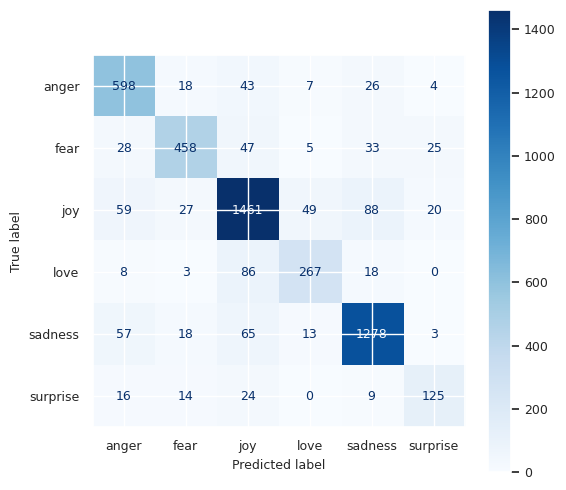


Classification Report

              precision    recall  f1-score   support

       anger       0.78      0.86      0.82       696
        fear       0.85      0.77      0.81       596
         joy       0.85      0.86      0.85      1704
        love       0.78      0.70      0.74       382
     sadness       0.88      0.89      0.89      1434
    surprise       0.71      0.66      0.68       188

    accuracy                           0.84      5000
   macro avg       0.81      0.79      0.80      5000
weighted avg       0.84      0.84      0.84      5000



In [89]:
y_pred = modelo_recurrente_bi.predict(test_sequences)
y_pred = y_pred.argmax(axis=1)
get_detailed_report(le_test,y_pred,le.classes_)

Agregar bidireccionalidad no pareciera mejorar el rendimiento promedio del modelo.

## Word Embeddings Aprendidos por la Red

Como la primera capa de su modelo recurrente es una capa de tipo Embedding, es posible examinar las representaciones que el modelo ha aprendido para cada palabras. Se espera que estas representaciones vectoriales, comúnmente llamadas word embeddings, preserven la semántica de los términos más importantes en el corpus de interés.


*   Extraiga la representación aprendida por la red para las palabras del vocabulario y examine algunos casos para determinar si la proximidad en el espacio  latente está relacionada con la proximidad semántica de dos términos.

In [34]:
word_index = Seq_tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

embedding_layer = modelo_recurrente.layers[1]
weights = embedding_layer.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(5000, 32)


In [35]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=20, algorithm='brute', metric='cosine').fit(weights)

In [36]:
distances, indices = nbrs.kneighbors([weights[word_index['angry'],:]])

In [37]:
for idx in indices[0,:]:
  print(reverse_word_index[idx])

angry
impatient
hostile
disgusted
offended
angered
bitchy
dissatisfied
grouchy
stubborn
grumpy
insulted
distracted
irritated
heartless
greedy
jealous
cranky
mad
rude


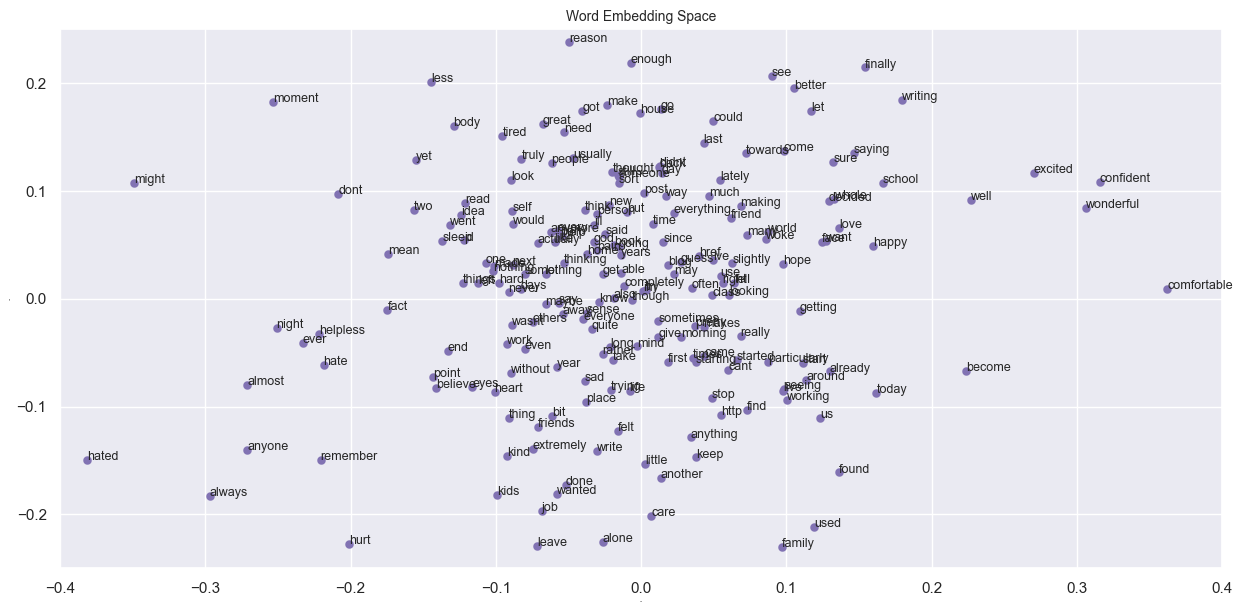

In [38]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
proyeccion = pca.fit_transform(weights)

num_inicial=1
num_plot=240
num_final=num_inicial+num_plot

plt.figure(figsize=(15,7))
plt.scatter(proyeccion[num_inicial:num_final,0],proyeccion[num_inicial:num_final,1],linewidths=.1,color='m')
plt.xlabel("PC1",size=1)
plt.ylabel("PC2",size=1)
plt.title("Word Embedding Space",size=10)

for word_idx in range(num_inicial, num_final):
  word = reverse_word_index[word_idx]
  plt.annotate(word,xy=(proyeccion[word_idx,0],proyeccion[word_idx,1]),size=9)

plt.xlim([-0.4, 0.4])
plt.ylim([-0.25, 0.25])
plt.show()

En el gráfico puede verse una tendencia a mantener palabras semánticamente cercanas en posiciones relativamente parecidas; por ejemplo, palabras con connotación negativa como "helpless", "hate", "hated" y "hurt" tienden a estar ubicadas en posiciones en el tercer cuadrante (abajo izquierda), mientras que palabras con una connotación más positiva, como "excited", "confident", "wonderful", "well", "happy" y "love" tienden a estar ubicadas en el primer cuadrante (arriba derecha).

# 6. Word Embeddings Pre-entrenados

Como sabemos, una forma de mejorar el desempeño de un modelo en una tarea consiste en transferir el conocimiento adquirido en otra tarea similar. En esta sección, evaluaremos el beneficio de esta estrategia explotando *word embeddings* pre-aprendidos sobre grandes bases de datos.


*   Averigue cómo fueron entrenadas las representaciones GloVe que se descargan más abajo y que dimensiones tienen los embeddings disponibles.


## Download

In [51]:
!curl http://nlp.stanford.edu/data/glove.twitter.27B.zip

<!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">
<html><head>
<title>302 Found</title>
</head><body>
<h1>Found</h1>
<p>The document has moved <a href="https://cs.stanford.edu/srcf_404">here</a>.</p>
</body></html>


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   216  100   216    0     0    590      0 --:--:-- --:--:-- --:--:--   590
100   216  100   216    0     0    590      0 --:--:-- --:--:-- --:--:--   590


In [ ]:
!unzip glove.twitter.27B.zip

In [53]:
emd_dim = 200

emb_dict = {}

glove_file = 'glove.twitter.27B.' + str(emd_dim) + 'd.txt'
glove_dir = ''#path to the file

glove = open(glove_dir+glove_file)
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector

glove.close()

In [54]:
a = emb_dict.get("flight")
print(type(a))

<class 'numpy.ndarray'>


GloVe es un algoritmo de aprendizaje no-supervisado que busca generar embeddings analizando matrices de co-ocurrencias de palabras en un corpus, la que básicamente muestra qué tan seguido aparecen juntos cada par de palabras. El objetivo de esta matriz es capturar relaciones estadísticas entre palabras basadas en sus patrones de co-ocurrencia. Luego se inicializan vectores de palabras, en un espacio con la cantidad de dimensiones que se consideren necesarias, y se establece una función objetivo para un problema de minimización, que busca acercar los vectores de palabras que según la matriz de co-ocurrencia deberían aparecer juntos.

En este caso, se dispone de 4 conjuntos de embeddings, con 25, 50, 100 y 200 dimensiones.

## Populate Embedding Matrix

*   Compute embeddings para los términos del vocabulario utilizado para entrenar el RNN de la sección anterior. Almacene los resultados en una matriz, manteniendo el orden original en que se indexan los diferentes términos del vocabulario. Esto nos permitirá utilizar esta matriz para inicializar la primera capa de la red.

*   Determine para cuántos términos del vocabulario no se encuentran embeddings y defina una estrategia para manejar estos casos. Compruebe que usando stemming, la cantidad de términos no encontrados se eleva significativamente y que por lo tanto no conviene incluir este paso en el pre-procesamiento del texto.

*   Examine algunos casos para determinar si la proximidad de los embeddings Glove está relacionada con la proximidad semántica (significado) de los términos respectivos.

In [65]:
n_max_words_vis = 5000
wcounts = list(Seq_tokenizer.word_counts.items())
wcounts.sort(key=lambda x: x[1], reverse=True)
top_words = wcounts[:n_max_words_vis]
top_words = [w[0] for w in top_words]
reverse_word_index = dict([(value, key) for (key, value) in Seq_tokenizer.word_index.items()])

In [66]:
top_words[:10]

['feel',
 'feeling',
 'like',
 'im',
 'really',
 'know',
 'time',
 'little',
 'people',
 'get']

In [67]:
word_index = Seq_tokenizer.word_index
emb_matrix = np.zeros((n_max_words, emd_dim))

not_found = 0
for word in top_words[:-1]:
  vect = emb_dict.get(word)
  idx_word = word_index[word]
  if vect is not None:
    emb_matrix[idx_word] = vect
  else:
    emb_matrix[idx_word] = np.random.normal(0,0.1,emd_dim) # (La estrategia es asignar un vector aleatorio)
    not_found+=1

print("Palabras del Diccionario no Encontradas en Glove ", not_found, " DE ", n_max_words)

Palabras del Diccionario no Encontradas en Glove  130  DE  5000


In [64]:
# Probando con stemming:
cleaned_train_2 = [preprocess(tweet,cleaning=True,stopwords=True,stemming=True) for tweet in train_tweets]
cleaned_val_2 = [preprocess(tweet,cleaning=True,stopwords=True,stemming=True) for tweet in val_tweets]
cleaned_test_2 = [preprocess(tweet,cleaning=True,stopwords=True,stemming=True) for tweet in test_tweets]

n_max_words = 5000

Seq_tokenizer_2 = Tokenizer(num_words=n_max_words)
Seq_tokenizer_2.fit_on_texts(cleaned_train_2)

train_sequences_2 = Seq_tokenizer_2.texts_to_sequences(cleaned_train_2)
val_sequences_2 = Seq_tokenizer_2.texts_to_sequences(cleaned_val_2)
test_sequences_2 = Seq_tokenizer_2.texts_to_sequences(cleaned_test_2)

n_max_words_vis = 5000
wcounts_2 = list(Seq_tokenizer_2.word_counts.items())
wcounts_2.sort(key=lambda x: x[1], reverse=True)
top_words_2 = wcounts_2[:n_max_words_vis]
top_words_2 = [w[0] for w in top_words_2]
reverse_word_index_2 = dict([(value, key) for (key, value) in Seq_tokenizer_2.word_index.items()])

word_index_2 = Seq_tokenizer_2.word_index
emb_matrix_2 = np.zeros((n_max_words, emd_dim))

not_found = 0
for word in top_words_2[:-1]:
  vect = emb_dict.get(word)
  idx_word = word_index_2[word]
  if vect is not None:
    emb_matrix[idx_word] = vect
  else:
    emb_matrix[idx_word] = np.random.normal(0,0.1,emd_dim) # (La estrategia es asignar un vector aleatorio)
    not_found+=1

print("Palabras del Diccionario no Encontradas en Glove ", not_found, " DE ", n_max_words)

Palabras del Diccionario no Encontradas en Glove  855  DE  5000


Efectivamente, usando stemming, se logran encontrar menos palabras en el dataset de GloVe, por lo que no es conveniente usarlo en este caso.

### Search Neighbours

In [39]:
print(emb_matrix.shape)

(5000, 200)


In [68]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=20, algorithm='brute', metric='cosine').fit(emb_matrix)

In [69]:
test_word = 'angry'
distances, indices = nbrs.kneighbors([emb_matrix[word_index[test_word ],:]])
for idx in indices[0,:]:
  print(reverse_word_index[idx])

angry
birds
mad
annoyed
upset
frustrated
pissed
confused
stupid
bird
sometimes
annoying
cry
sad
depressed
people
little
jealous
scared
tired


In [70]:
test_word = 'happy'
distances, indices = nbrs.kneighbors([emb_matrix[word_index[test_word ],:]])
for idx in indices[0,:]:
  print(reverse_word_index[idx])

happy
birthday
day
wish
love
year
hope
thank
enjoy
good
thanks
christmas
wishes
everyone
always
much
today
morning
friend
celebrate


Pareciera que los vectores más próximos en el dataset de GloVe sí tienden a ser palabras que tienen un contenido semántico similar, como se puede ver que vectores cercanos a "angry" son "mad", "annoyed" y "upset", mientras que vectores cercanos a "happy" son "hope", "enjoy" y "good". 

Cabe notar que se puede ver que estas aproximaciones se hacen notoriamente en base a palabras que suelen ser escritas en los mismos textos, lo cual puede significar que palabras que no son cercanas semánticamente tengan vectores cercanos de todas formas. Esto es lo que se puede observar entre "angry" y su palabra más cercana según GloVe: "birds"; estas dos palabras no guardan cercanía semántica, pero existe una tendencia estadística a que estén juntas debido al juego "angry birds".

## RNN Pre-calentada


*  Utilice los embeddings Glove para inicializar la red recurrente empleada en la sección anterior. En base a lo observado en la sección anterior, decida si utilizar o no stemming para pre-procesar el texto. Entrene el modelo resultante y determine si se obtienen mejoras en la tarea objetivo. Determine también si existe un costo a pagar en términos computacionales.

In [71]:
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, SpatialDropout1D

emd_dim = 32

def RNN_warm(pre_trained_we,max_text_length,fine_tune_we=False):
  input_sequence = keras.Input(shape=(max_text_length),dtype="int64")
  embedded_sequence = Embedding(pre_trained_we.shape[0], pre_trained_we.shape[1])(input_sequence)
  embedded_sequence = SpatialDropout1D(0.25)(embedded_sequence)
  #recurrent = LSTM(25,return_sequences=False)(embedded_sequence)
  recurrent = LSTM(25,return_sequences=True)(embedded_sequence)
  recurrent = SpatialDropout1D(0.25)(recurrent)
  recurrent = LSTM(25,return_sequences=False)(recurrent)
  recurrent = Dense(25, activation='relu')(recurrent)
  sentiment = Dense(len(emotions),activation="softmax")(recurrent)
  modelo_recurrente = keras.Model(input_sequence, sentiment)
  modelo_recurrente.layers[1].set_weights([pre_trained_we])
  modelo_recurrente.layers[1].trainable = fine_tune_we
  return modelo_recurrente

In [136]:
import tensorflow_addons as tfa
METRICS = [
      tf.metrics.BinaryAccuracy(name='accuracy'),
      tfa.metrics.F1Score(name='F1',average='macro',num_classes=len(emotions))
]

In [138]:
from tensorflow.keras.optimizers import SGD, Adam

modelo_recurrente_wep = RNN_warm(emb_matrix,max_text_length,fine_tune_we=False)
modelo_recurrente_wep.summary()

opt = Adam()
modelo_recurrente_wep.compile(loss='categorical_crossentropy', metrics=METRICS, optimizer=opt)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 25)]              0         
                                                                 
 embedding_19 (Embedding)    (None, 25, 200)           1000000   
                                                                 
 spatial_dropout1d_6 (Spatia  (None, 25, 200)          0         
 lDropout1D)                                                     
                                                                 
 lstm_6 (LSTM)               (None, 25, 25)            22600     
                                                                 
 spatial_dropout1d_7 (Spatia  (None, 25, 25)           0         
 lDropout1D)                                                     
                                                                 
 lstm_7 (LSTM)               (None, 25)                510

In [139]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_F1', factor=0.2, patience=5, min_lr=0.001)
es = tf.keras.callbacks.EarlyStopping(monitor='val_F1', patience=5, restore_best_weights=True, mode='max')
history_recurrente_wep = modelo_recurrente_wep.fit(train_sequences, y_train, epochs=40, batch_size=32, validation_data=(val_sequences, y_val), callbacks=[es])


Epoch 1/40
157/157 [==============================] - 9s 18ms/step - loss: 1.5461 - accuracy: 0.8353 - F1: 0.1731 - val_loss: 1.4153 - val_accuracy: 0.8506 - val_F1: 0.1995
Epoch 2/40
157/157 [==============================] - 2s 13ms/step - loss: 1.2964 - accuracy: 0.8548 - F1: 0.2135 - val_loss: 1.2337 - val_accuracy: 0.8655 - val_F1: 0.2270
Epoch 3/40
157/157 [==============================] - 2s 13ms/step - loss: 1.1540 - accuracy: 0.8725 - F1: 0.2707 - val_loss: 1.0525 - val_accuracy: 0.8773 - val_F1: 0.3145
Epoch 4/40
157/157 [==============================] - 3s 17ms/step - loss: 0.9921 - accuracy: 0.8876 - F1: 0.4077 - val_loss: 0.8618 - val_accuracy: 0.9036 - val_F1: 0.4800
Epoch 5/40
157/157 [==============================] - 3s 20ms/step - loss: 0.8492 - accuracy: 0.9030 - F1: 0.4970 - val_loss: 0.7531 - val_accuracy: 0.9128 - val_F1: 0.5126
Epoch 6/40
157/157 [==============================] - 2s 15ms/step - loss: 0.7470 - accuracy: 0.9174 - F1: 0.5489 - val_loss: 0.6647 - 

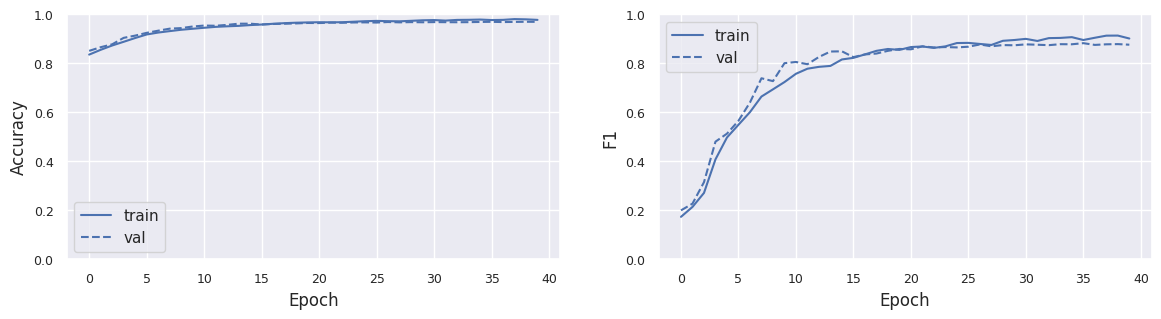

In [141]:
mpl.rcParams['figure.figsize'] = (14, 7)
plot_metrics(history_recurrente_wep)

In [143]:
y_pred = modelo_recurrente_wep.predict(test_sequences)
y_pred = y_pred.argmax(axis=1)

157/157 [==============================] - 2s 4ms/step



ACCURACY TEST FINAL:  0.9128

Confusion Matrix



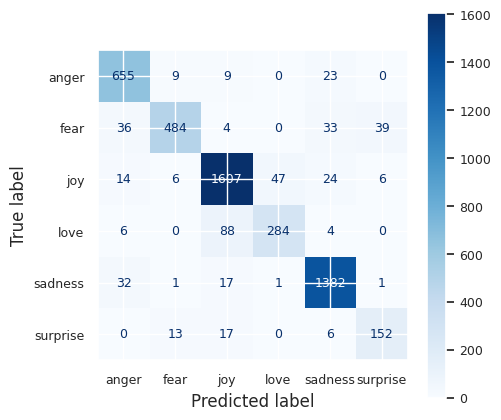


Classification Report

              precision    recall  f1-score   support

       anger       0.88      0.94      0.91       696
        fear       0.94      0.81      0.87       596
         joy       0.92      0.94      0.93      1704
        love       0.86      0.74      0.80       382
     sadness       0.94      0.96      0.95      1434
    surprise       0.77      0.81      0.79       188

    accuracy                           0.91      5000
   macro avg       0.88      0.87      0.88      5000
weighted avg       0.91      0.91      0.91      5000



In [144]:
get_detailed_report(le_test,y_pred,le.classes_)

Se puede observar que utilizar los embeddings de GloVe mejora considerablemente el rendimiento del modelo, llegando a aumentar su f1-score promedio en al rededor de 10 puntos porcentuales, y disminuyendo aún más la confusión entre clases observada anteriormente.

# 7. Custom Transformer

*   Explique cúales son las dos operaciones o transformaciones que componen un bloque constructivo básico en el encoder empleado por un Transformer para procesar secuencias.

In [35]:
from tensorflow.keras import layers
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

Los bloques básicos del encoder en un Transformer para secuencias tienen dos operaciones clave: <br>
-Atención multi-cabezal: Se tienen "cabezales" en paralelo que realizan operaciones matriciales utilizando como base la abstracción "consulta/llave/valor" que se generan a partir de las secuencias de entrada. Estos cálculos se combinan y se transforman en una salida ponderada que busca capturar la importancia de diferentes posiciones de la secuencia original.<br>
-Position-Wise Feed-Forward Layers: La idea es utilizar los atributos de la representación de entrada, "desenredarlos" mediante una representación de mayor dimensionalidad y recombinarlos en una salida de igual dimensionalidad que la entrada, creando nuevos atributos.

*   Explique en que difieren los encodings posicionales usados por el código de más abajo respecto de aquellos originalmente propuestos para el Transformer.

In [36]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

La diferencia entre estos encodings posicionales respecto a los que orginalamente se han propuesto para el Transformer, es que en estos últimos se había propuesto utilizar funciones trigonométricas para condificación posicional, donde cada dimensión del embedding es una sinusoide con diferente frecuencia. En este código, en cambio utiliza el mismo tipo de embedding tradicional tanto para los tokens como para las posiciones, que luego son sumados.

## Modelo

*  Defina un encoder de tipo Transformer con dos bloques constructivos básicos, uno apilado sobre el otro. Averigue qué hace exactamente una capa de tipo *GlobalAveragePooling1D* y úsela para construir un clasificador que aproveche la representación más profunda aprendida por el encoder para predecir las emociones con las que se asocia el texto de entrada.

In [37]:
vocab_size = 5000
maxlen = 25
embed_dim = 32

In [38]:
def transformer_model(num_heads=2,ff_dim=64):
  inputs = layers.Input(shape=(maxlen,))
  embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
  x = embedding_layer(inputs)
  x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
  x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
  x = layers.GlobalAveragePooling1D()(x)
  x = layers.Dropout(0.1)(x)
  x = layers.Dense(20, activation="relu")(x)
  x = layers.Dropout(0.1)(x)
  outputs = layers.Dense(len(emotions), activation="softmax")(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

La capa de "GlobalAveragePooling1D" permite reducir el largo de la secuencia obtenida desde el bloque de transformer a largo 1, manteniendo el mismo número de features.

*   Sin entrenar el modelo, explore cómo aumenta la cantidad de parámetros entrenables cuando se aumenta la longitud máxima de las secuencias a procesar e, independientemente, cuando se aumenta el tamaño de las representaciones que asigna el modelo a cada posición en la secuencia de entrada.

In [39]:
transformer_ = transformer_model(num_heads = 3, ff_dim = 64)
transformer_.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 25)]              0         
                                                                 
 token_and_position_embeddin  (None, 25, 32)           160800    
 g_3 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_6 (Transf  (None, 25, 32)           16928     
 ormerBlock)                                                     
                                                                 
 transformer_block_7 (Transf  (None, 25, 32)           16928     
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_3   (None, 32)               0   

Aumentar el largo de las secuencias con "maxlen" no parece tener un gran impacto en la cantidad de parámetros entrenables del modelo - sólo cambian los parámetros entrenables entre la capa de input y la capa de embeddings. Por otro lado, cambiar la cantidad de dimensiones de los vectores de embeddings tiene un gran impacto; la cantidad de parámetros entrenables del modelo parece crecer proporcionalmente según este parámetro.

## Entrenamiento

*   Entrene su pequeño Transformer para determinar si obtiene mejoras con respecto a los modelos utilizados anteriormente. Para simplificar, represente el texto sin eliminar stopwords y sin hacer stemming, eligiendo un tamaño máximo de entrada consistente con esta decisión.

In [40]:
import tensorflow_addons as tfa
METRICS = [
      tf.metrics.BinaryAccuracy(name='accuracy'),
      tfa.metrics.F1Score(name='F1',average='macro',num_classes=len(emotions))
]

In [41]:
transformer_ = transformer_model(num_heads = 2,ff_dim = 64)
transformer_.compile(optimizer="adam", loss="categorical_crossentropy", metrics=METRICS)
transformer_.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 25)]              0         
                                                                 
 token_and_position_embeddin  (None, 25, 32)           160800    
 g_4 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_8 (Transf  (None, 25, 32)           12736     
 ormerBlock)                                                     
                                                                 
 transformer_block_9 (Transf  (None, 25, 32)           12736     
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_4   (None, 32)               0   

In [43]:
print(val_sequences)

[[1, 2, 95, 1043, 9, 1, 17, 27, 6, 944], [1, 37, 27, 13, 30, 7, 292], [1, 337, 54, 7, 985, 25, 71, 8, 11, 1106, 1, 337, 63, 3003, 2788], [1, 40, 2, 5, 894, 15, 3380, 560, 955, 4, 10, 658, 8, 277], [18, 297, 4, 2, 38, 240, 29, 927], [1, 2, 14, 732, 4, 62], [1, 122, 2, 71, 404, 11, 10, 1924, 104, 144, 19, 72, 12, 20, 5, 36, 9, 2341, 55, 5, 3090, 4, 5, 1924], [1, 2, 960, 3, 484], [1, 94, 37, 11, 5, 2202, 1, 40, 267, 10, 329, 23, 6, 1, 94, 37, 2001, 44, 1, 94, 33, 102, 4, 467, 3, 268, 22, 87, 1, 2, 545, 3, 543], [1, 21, 297, 4, 2, 1213, 15, 118, 57, 335, 133, 261, 2152, 8, 107, 11, 5, 1705, 1149], [91, 874, 6, 190, 8, 10, 176, 11, 3543, 2235, 2604, 14, 18, 7, 95, 833, 4, 184, 68, 28, 11, 5, 737, 8, 1633], [1, 60, 1471, 199, 11, 118, 224, 533, 33, 2135, 170, 587, 22, 24, 50, 20, 451, 1, 17, 58, 3073, 5, 2576, 140, 76, 288, 7, 5, 3, 9, 97, 177, 31, 155, 6, 585, 1010], [1, 17, 297, 4, 2, 232], [1, 2, 565, 3, 12, 21, 186, 139, 484], [1, 64, 2, 24, 20, 68, 8, 5, 121, 777, 193, 4284], [1, 2, 25,

In [51]:
cleaned_train = [preprocess(tweet,cleaning=True,stopwords=False,stemming=False) for tweet in train_tweets]
cleaned_val = [preprocess(tweet,cleaning=True,stopwords=False,stemming=False) for tweet in val_tweets]
cleaned_test = [preprocess(tweet,cleaning=True,stopwords=False,stemming=False) for tweet in test_tweets]

n_max_words = 5000

Seq_tokenizer = Tokenizer(num_words=n_max_words)
Seq_tokenizer.fit_on_texts(cleaned_train)

train_sequences = Seq_tokenizer.texts_to_sequences(cleaned_train)
val_sequences = Seq_tokenizer.texts_to_sequences(cleaned_val)
test_sequences = Seq_tokenizer.texts_to_sequences(cleaned_test)

max_text_length = 25
train_sequences = pad_sequences(train_sequences, maxlen=max_text_length)
val_sequences = pad_sequences(val_sequences, maxlen=max_text_length)
test_sequences = pad_sequences(test_sequences, maxlen=max_text_length)

history_trasformer = transformer_.fit(train_sequences, y_train, epochs=40, batch_size=32, validation_data=(val_sequences, y_val), verbose=0)

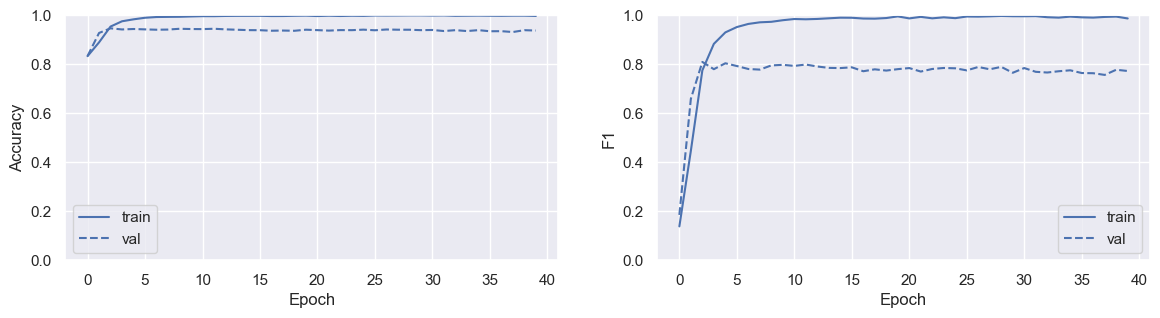

In [54]:
mpl.rcParams['figure.figsize'] = (14, 7)
plot_metrics(history_trasformer)

In [55]:
y_pred_trans = transformer_.predict(test_sequences)
y_pred_trans = y_pred_trans.argmax(axis=1)
print(y_pred_trans.shape)

157/157 [==============================] - 1s 3ms/step
(5000,)



ACCURACY:  0.8148

Confusion Matrix



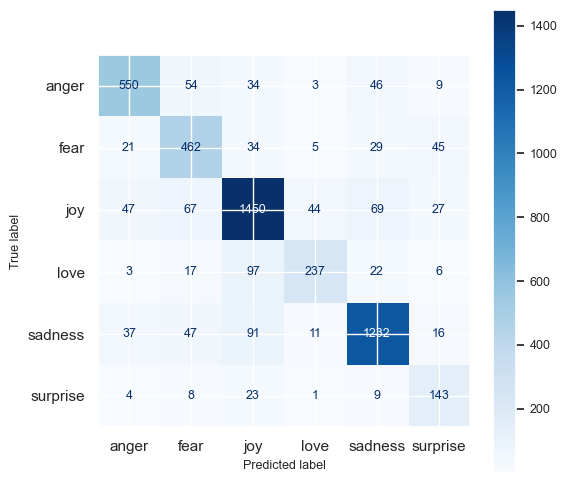


Classification Report

              precision    recall  f1-score   support

       anger       0.83      0.79      0.81       696
        fear       0.71      0.78      0.74       596
         joy       0.84      0.85      0.84      1704
        love       0.79      0.62      0.69       382
     sadness       0.88      0.86      0.87      1434
    surprise       0.58      0.76      0.66       188

    accuracy                           0.81      5000
   macro avg       0.77      0.78      0.77      5000
weighted avg       0.82      0.81      0.82      5000



In [58]:
get_detailed_report(le_test, y_pred_trans, le.classes_)

El modelo de transformer resulta más efectivo que la red FNN, tiene un rendimiento similar a la RNN utilizada inicialmente y tiene un rendimiento peor que la RNN con embeddings preentrenados. Esto, sin eliminar stopwords, utilizar stemming ni equilibrar las clases con Oversampling.

# 8. Finetuning BERT

BERT es uno de los modelos neuronales más utilizados actualmente para procesar lenguaje natural. Una de sus principales ventajas respecto de modelos más sencillos como Glove es que permite extraer representaciones contextuales de palabras y frases completas aprovechando para esto la flexibilidad un modelo basado en atención como el Transformer. En esta sección construiremos un clasificador usando BERT pre-entrenado.

## Librerías y Útiles

In [ ]:
!pip install bert-for-tf2

In [ ]:
!pip install tensorflow-text

## Construcción del Modelo

Los pasos que siguen envuelven un modelo BERT pre-entrenado como capa de la librería Keras de modo de poder usarlo como bloque de construcción en un clasificador. Note que puede declarar la capa como entrenable o no dependiendo de la estrategia de transferencia que se desee implementar.

In [26]:
import tensorflow_hub as hub
bert_path = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'
bert_layer = hub.KerasLayer(bert_path, trainable=True)

Para operar con BERT es necesario crear un Tokenizador específico de ese modelo que descompone en texto en piezas de información (tokens) de modo algo más sofisticado que la metodología que hemos venido empleando (trozos de palabras en vez de palabras completas).

In [27]:
import bert
from bert.tokenization.bert_tokenization import FullTokenizer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
bert_tokenizer = FullTokenizer(vocab_file, do_lower_case)

*   Averigue cómo se entrena BERT para entender porqué es necesario pre-procesar cada texto para generar tres secuencias de entrada diferentes como se muestra en la celda de más abajo.



In [28]:
def prepare_input_for_bert(texts, bert_tokenizer, max_seq_len):
  x, y, z =[],[], []
  for text in texts:
    tokens = bert_tokenizer.tokenize(text)
    tokens = tokens[:min(len(tokens),max_seq_len-2)]
    tokens = ["[CLS]"]+tokens+["[SEP]"]
    token_ids = bert_tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_len-len(token_ids))
    input_mask = ([1] * len(token_ids)) + ([0] *  (max_seq_len - len(token_ids)))
    input_type = ([0] * (len(token_ids)-1)) + [1] + ([0] *  (max_seq_len - len(token_ids)))
    x.append(np.array(input_ids))
    y.append(np.array(input_mask))
    z.append(np.array(input_type))
  return [tf.cast(np.array(x),tf.int32), tf.cast(np.array(y),tf.int32), tf.cast(np.array(z),tf.int32)]


Bert es entrenado mediante dos tareas: masked language modeling y next sentence prediction. La primera busca enmascarar aleatoriamente ciertos tokens en las secuencias de entrada, y el objetivo del modelo es predecir los tokens enmascarados utilizando el contexto proporcionado por otros tokens; esto, para evitar que las palabras tengan un significado fijo que no varía según el contexto. Antes del entrenamiento, al rededor de un 15% de las palabras de cada secuencia son seleccionadas para: ser reemplazadas con un token \[MASK\] (80% de los casos), una palabra al azar (10% de los casos) o no ser reemplazadas (10% de los casos).<br>
La segunda hace que BERT reciba pares de oraciones como input, y aprenda a predecir si la segunda oración sigue a la primera en el documento original. Al rededor de un 50% de los inputs son pares en que el segundo sí sigue al primero, mientras que el otro 50% son pares aleatorios.<br>

Considerando estas dos tareas, se generan las tres secuencias del código por las siguientes razones:<br>
-input_ids: Permite al modelo entender qué palabras o subpalabras están presentes en el textos. Los tokens se convierten en enteros mediante el tokenizer, y los identificadores de token son índices únicos asignados a cada token en el vocabulario de BERT.<br>
-input_mask: Indica qué tokens son parte del texto real y cuáles son tokens de relleno (1 para textos reales y 0 para relleno). Estos se agregan, además, para asegurar que todas las secuencias de entrada tengan la misma longitud.<br>
-input_type: Es una lista de la misma longitud que input_ids, que indica qué segmento pertenece a cada token; si se están alimentando dos oraciones separadas al modelo, los tokens de la primera oración tendrán un valor de 0 y los de la segunda tendrán un valor de 1, lo que es útil para el uso de next sentence prediction.


*   Extienda el modelo BERT para que permita resolver la tarea considerada en este taller. Para permitir mayor flexibilidad, incorpore una capa oculta antes de la capa de salida.

In [6]:
from tensorflow.keras.layers import Dropout, Permute, SpatialDropout1D
def bert_based_model(max_seq_len):

  input_ids = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_ids")
  input_mask = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_masks")
  input_segments = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_segments")
  pooled_output, sequence_output = bert_layer([input_ids, input_mask, input_segments])
  cls_out = keras.layers.GlobalAveragePooling1D()(sequence_output)
  logits = keras.layers.Dropout(0.7)(cls_out)
  logits = keras.layers.Dense(768)(logits)
  logits = keras.layers.Dropout(0.7)(logits)
  logits = keras.layers.Dense(len(emotions), activation="softmax")(logits)
  classifier = keras.Model([input_ids, input_mask, input_segments],logits)

  return classifier

## Entrenamiento

Note que el tamaño máximo de secuencia se impone acá independientemente de la sección 5.

In [13]:
max_seq_len=50
bert_input_train = prepare_input_for_bert(train_tweets,bert_tokenizer,max_seq_len)
bert_input_val = prepare_input_for_bert(val_tweets,bert_tokenizer,max_seq_len)
bert_input_test = prepare_input_for_bert(test_tweets,bert_tokenizer,max_seq_len)
print(bert_input_train[0].shape)

(5000, 50)


In [21]:
bert_model = bert_based_model(max_seq_len)
bert_model.summary()
bert_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=METRICS)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 50)]         0           []                               
                                                                                                  
 input_segments (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_ids[0][0]',              
                                 (None, 50, 768)]                 'input_masks[0][0]',      

*   Entrene el modelo basado en BERT para determinar si obtiene o no ventajas respecto de los modelos evaluados hasta el momento. Por ahora mantenga todos los parámetros del modelo base como entrenables y utilice una estrategia de pre-procesamiento del texto coherente con lo que se espera de BERT. Elija un tamaño máximo de secuencia compatible con los largos observados de los textos a procesar.

In [113]:
checkpoint_path = 'BERT_based_checkpoints/BERT_based.{epoch:02d}-{val_F1:.4f}.h5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,save_best_only=True,monitor='val_F1',mode='max')
es = tf.keras.callbacks.EarlyStopping(monitor='val_F1', patience=5, restore_best_weights=True, mode='max')
history_bert_model = bert_model.fit(bert_input_train, y_train, epochs=40, batch_size=32, validation_data=(bert_input_val, y_val), callbacks=[es])

Epoch 1/40
157/157 [==============================] - 130s 292ms/step - loss: 0.5264 - accuracy: 0.8287 - F1: 0.2084 - val_loss: 0.4073 - val_accuracy: 0.8406 - val_F1: 0.0951
Epoch 2/40
157/157 [==============================] - 28s 181ms/step - loss: 0.4512 - accuracy: 0.8196 - F1: 0.1944 - val_loss: 0.3365 - val_accuracy: 0.8688 - val_F1: 0.2198
Epoch 3/40
157/157 [==============================] - 31s 198ms/step - loss: 0.3073 - accuracy: 0.8928 - F1: 0.4424 - val_loss: 0.1721 - val_accuracy: 0.9292 - val_F1: 0.6027
Epoch 4/40
157/157 [==============================] - 27s 175ms/step - loss: 0.1558 - accuracy: 0.9541 - F1: 0.7579 - val_loss: 0.1035 - val_accuracy: 0.9606 - val_F1: 0.8332
Epoch 5/40
157/157 [==============================] - 29s 187ms/step - loss: 0.0804 - accuracy: 0.9763 - F1: 0.8782 - val_loss: 0.0911 - val_accuracy: 0.9682 - val_F1: 0.8723
Epoch 6/40
157/157 [==============================] - 29s 188ms/step - loss: 0.0520 - accuracy: 0.9862 - F1: 0.9272 - val_lo

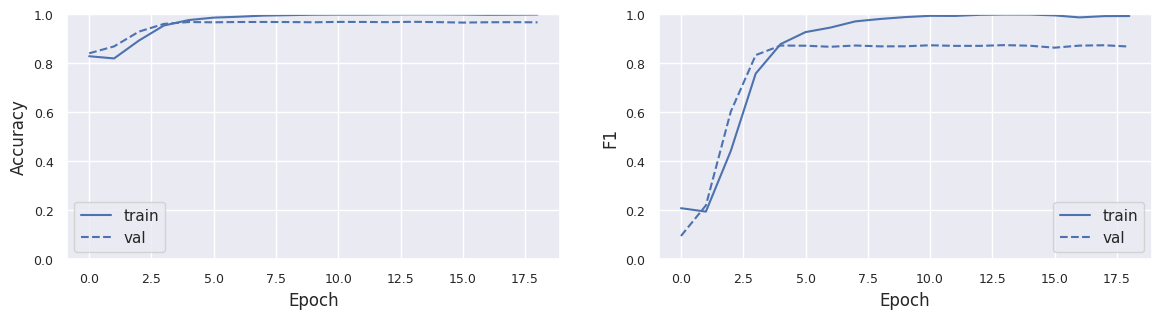

In [117]:
mpl.rcParams['figure.figsize'] = (14, 7)
plot_metrics(history_bert_model)

In [118]:
y_pred_bert =  bert_model.predict(bert_input_test)
y_pred_bert = y_pred_bert.argmax(axis=1)
print(y_pred_bert.shape)

157/157 [==============================] - 6s 38ms/step
(5000,)



ACCURACY:  0.9122

Confusion Matrix



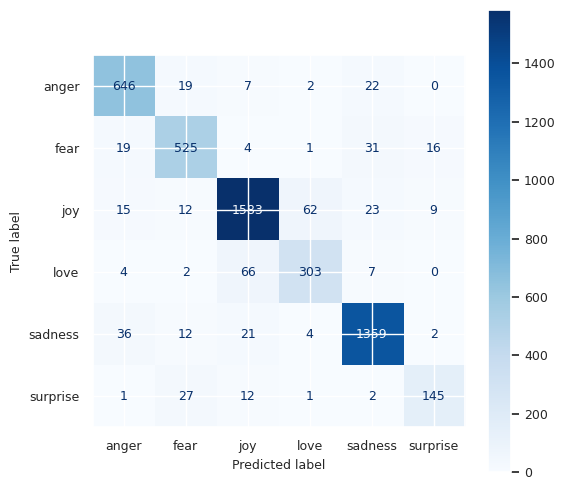


Classification Report

              precision    recall  f1-score   support

       anger       0.90      0.93      0.91       696
        fear       0.88      0.88      0.88       596
         joy       0.94      0.93      0.93      1704
        love       0.81      0.79      0.80       382
     sadness       0.94      0.95      0.94      1434
    surprise       0.84      0.77      0.81       188

    accuracy                           0.91      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.91      0.91      0.91      5000



In [119]:
get_detailed_report(le_test, y_pred_bert, le.classes_)

El modelo basado en BERT se desempeña mejor que todos los modelos anteriores, con un f1-score que es en promedio cercano a 0.9; aunque, tiene un rendimiento similar al obtenido mediante la RNN con los embeddings preentrenados de GloVe.

## Análisis

*   Averigue qué hacen las capas de pooling incluídas en el modelo propuesto y determine si son efectivamente relevantes para obtener un buen desempeño. Intente explicar lo que observa.

In [ ]:
def bert_based_model_2(max_seq_len): # (sin dropout)

  input_ids = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_ids")
  input_mask = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_masks")
  input_segments = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_segments")
  pooled_output, sequence_output = bert_layer([input_ids, input_mask, input_segments])
  cls_out = keras.layers.GlobalAveragePooling1D()(sequence_output)
  logits = keras.layers.Dense(len(emotions), activation="softmax")(cls_out)
  classifier = keras.Model([input_ids, input_mask, input_segments],logits)

  return classifier

max_seq_len=50
bert_input_train = prepare_input_for_bert(train_tweets,bert_tokenizer,max_seq_len)
bert_input_val = prepare_input_for_bert(val_tweets,bert_tokenizer,max_seq_len)
bert_input_test = prepare_input_for_bert(test_tweets,bert_tokenizer,max_seq_len)
print(bert_input_train[0].shape)

bert_model = bert_based_model_2(max_seq_len)
bert_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=METRICS)

checkpoint_path = 'BERT_based_checkpoints_2/BERT_based.{epoch:02d}-{val_F1:.4f}.h5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,save_best_only=True,monitor='val_F1',mode='max')
es = tf.keras.callbacks.EarlyStopping(monitor='val_F1', patience=5, restore_best_weights=True, mode='max')
history_bert_model = bert_model.fit(bert_input_train, y_train, epochs=40, batch_size=128, validation_data=(bert_input_val, y_val), callbacks=[es])

Asumiendo que se refiere a las capas de dropout: Son una técnica de regularización, con la que se busca prevenir sobreajuste. La idea es que durante el entrenamiento se desactiven aleatoriamente neuronas de la capa anterior a la de dropout, lo que evita que el entrenamiento provoque que ciertas neuronas dependan en exceso de otras (coadaptación). También puede actuar agregando ruido al entrenamiento, lo que puede ayudar a una convergencia más rápida y a una mejor distribución del aprendizaje a lo largo de la red.

*   Determine si congelar el modelo BERT antes de usarlo como bloque de construcción, es decir, impidiendo que sus parámetros se especialicen en la tarea objetivo, permite mejorar los resultados observados hasta el momento.

In [ ]:
bert_layer_3 = hub.KerasLayer(bert_path, trainable=False)

def bert_based_model_3(max_seq_len):

  input_ids = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_ids")
  input_mask = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_masks")
  input_segments = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_segments")
  pooled_output, sequence_output = bert_layer_3([input_ids, input_mask, input_segments])
  cls_out = keras.layers.GlobalAveragePooling1D()(sequence_output)
  logits = keras.layers.Dropout(0.7)(cls_out)
  logits = keras.layers.Dense(768)(logits)
  logits = keras.layers.Dropout(0.7)(logits)
  logits = keras.layers.Dense(len(emotions), activation="softmax")(logits)
  classifier = keras.Model([input_ids, input_mask, input_segments],logits)

  return classifier

max_seq_len=50
bert_input_train = prepare_input_for_bert(train_tweets,bert_tokenizer,max_seq_len)
bert_input_val = prepare_input_for_bert(val_tweets,bert_tokenizer,max_seq_len)
bert_input_test = prepare_input_for_bert(test_tweets,bert_tokenizer,max_seq_len)
print(bert_input_train[0].shape)

bert_model = bert_based_model_3(max_seq_len)
bert_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=METRICS)

checkpoint_path = 'BERT_based_checkpoints_3/BERT_based.{epoch:02d}-{val_F1:.4f}.h5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,save_best_only=True,monitor='val_F1',mode='max')
es = tf.keras.callbacks.EarlyStopping(monitor='val_F1', patience=5, restore_best_weights=True, mode='max')
history_bert_model = bert_model.fit(bert_input_train, y_train, epochs=40, batch_size=128, validation_data=(bert_input_val, y_val), callbacks=[es])

# 9. Más Datos

Se dice que recolectar más y mejores datos generalmente "paga mejor" que cualquier mejora arquitectural de la red. ¿Es esto cierto?

*  Elija un modelo (posiblemente uno bueno) y determine si permitirle acceder a más datos de entrenamiento efectivamente mejora su desempeño en la tarea de interés.

In [86]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

cuanto_extra = 1000
extra_train = pd.read_csv(path+'tweet_emotions_extratrain.csv')
extra_train = extra_train.sample(n=cuanto_extra , random_state=44)
data_train_ = data_train.append(extra_train, ignore_index=True)
print(data_train_.shape)
print(data_train_.head(5))


(6000, 2)
                                               tweet  emotion
0  i feel his amorous allure then he smiles and i...     love
1               i woke up still feeling a bit morose  sadness
2            i just sit there not feeling not caring     love
3  i also had a gazillion other things that just ...     fear
4  i feel my ability to read others mind may the ...  sadness


<ipython-input-86-27592aa04c83>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_train_ = data_train.append(extra_train, ignore_index=True)
